# __Imports__

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
from os import path
from glob import glob
from cycler import cycler
from pylab import Rectangle

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from utils import formats, short_names, condition_name_dict, FIGURE_DIR, SUPPLEMENT_DIR, S6_DIR, SUMMARY_DIR, full_passed_turkers
from utils import read_cond_file, get_attr, calc_SSRT, filter_ssrt_subs

pandas2ri.activate()

%load_ext rpy2.ipython
%matplotlib inline

In [2]:
# SETTING UP R PACKAGES
try:
    BayesFactor = importr('BayesFactor')
except:
    rutils = importr('utils')
    rutils.install_packages('BayesFactor', repo="http://cran.rstudio.com/") 

try:
    tidyverse = importr('tidyverse')
except:
    utils = importr('utils')
    utils.install_packages('tidyverse', repo="http://cran.rstudio.com/") 
    tidyverse = importr('tidyverse')
    
try:
    lme4 = importr('lme4')
except:
    utils = importr('utils')
    utils.install_packages('lme4', repo="http://cran.rstudio.com/")
    lme4 = importr('lme4')
    
try:
    lmerTest = importr('lmerTest')
except:
    utils = importr('utils')
    utils.install_packages('lmerTest', repo="http://cran.rstudio.com/") 
    lmerTest = importr('lmerTest')
    
try:
    emmeans = importr('emmeans')
except:
    utils = importr('utils')
    utils.install_packages('emmeans', repo="http://cran.rstudio.com/") 
    emmeans = importr('emmeans')

# __Constants__


In [3]:
# create line style cycle
colorset=['c','g','b','y','r','m', '#ff7f0e']
linestyleset=['-', '--', ':', '-.']

linecolors=[]
linestyles=[]      
for color in colorset:
    for style in linestyleset:
        linecolors.append(color)
        linestyles.append(style)  

In [4]:
summary_files = glob('SummaryData/summarydata*')
summary_files = [i for i in summary_files if 'Matzke' not in i]
summary_files.sort()
summary_files += ['SummaryData/summarydataMatzke.csv'] #append Matzke data to keep preprint's order

data_files = glob('Data/Data*')
data_files = [i for i in data_files if 'Matzke' not in i]
data_files.sort()
data_files += ['Data/DataMatzke.xlsx'] #append Matzke data to keep preprint's order


# __Helper Functions__

In [5]:
def round_to_50(x, base=50):
    # Takes in a number a rounds it to the nearest 50 up in magnitude
    # Used for bounds in S6
    if x >= 0: #for positive #s, round up
        return base * np.ceil(x/base)
    else: #for negative #s, round down
        return base * np.floor(x/base)

In [6]:
def ci_bounds(pivot_df): #used for s6wCI
    """calculate confidence interval mean +- 1.96*std/sqrt(n)"""
    ssd_means = pivot_df.mean(axis=1)
    ssd_sds = pivot_df.std(axis=1)
    ssd_counts = pivot_df.count(axis=1)

    s = (1.96*ssd_sds)/np.sqrt(ssd_counts)
    lower = ssd_means - s
    upper = ssd_means + s
    return lower, upper

In [7]:
def ssrt_fulllong(cond_df, method='replacement', verbose=False):             
    SSRTs = []
    SSRTs_longSSDs = []
    all_subjects = cond_df.Subject.unique()
    if len(all_subjects)==522: #if turk sample, swap out all_subjects
        all_subjects = full_passed_turkers
    usable_subjects = filter_ssrt_subs(cond_df.loc[cond_df.Subject.isin(all_subjects)]) #in case of turkers, only check those who passed
    if verbose: print(f'{len(all_subjects) - len(usable_subjects)} subject(s) excluded')
    for subject in usable_subjects:
        subdata = cond_df.query('Subject == %d' % subject).copy()
        #subset to ignore neg SSDs, keep NaNs( = go and ignore rows) - NO LONGER
        SSRT, _ = calc_SSRT(subdata, method=method)
        SSRTs.append(SSRT)
        #Get SSRT after excluding SSDs < 200ms  
        subdata = subdata[(subdata.StopSignalDelay >= 200) | (subdata.StopSignalDelay.isnull())]
        SSRT, _ = calc_SSRT(subdata, method=method)
        SSRTs_longSSDs.append(SSRT)

    return(SSRTs, SSRTs_longSSDs)

In [8]:
def check_is_subset(ssd_subset, ssd_ranges):
    is_subset = False
    for check_range in ssd_ranges:
        is_subset = is_subset | (set(ssd_subset).issubset(set(check_range)))
    return(is_subset)

def get_widest_ssds(va_df):
    ssd_ranges = []
    subset_subjects = []
    starting_ssds = va_df[va_df.ssd < 200].ssd.unique()
    starting_ssds.sort()
    for starting_ssd in starting_ssds:
        #get ssds to iterate over
        remaining_ssds = va_df[va_df.ssd > starting_ssd].ssd.unique()
        remaining_ssds.sort()
        
        #clip off ssds if there is a gap (e.g. [100, 150, __, 250] - > [100, 150])
        differences = np.diff(np.append(starting_ssd, remaining_ssds))
        step = np.min(differences) #find the smallest difference, treat as the step between ssds
        skips_idx = (differences>step) #look for gaps > the expected step
        skips = remaining_ssds[skips_idx] #find ssds that are the result of a skip (e.g. 250 in the above example)
        if len(skips)>0:
            remaining_ssds = remaining_ssds[remaining_ssds<skips[0]] #clip off everything before the first skip

        #set up current subset
        ssd_subset = [starting_ssd]
        shared_subs = va_df[va_df.ssd == starting_ssd].subject.unique()    
        shared_subs_out = shared_subs.copy()
        
        for curr_ssd in remaining_ssds:
            #get intersection of subs from past to newest ssd
            shared_subs = list(set(shared_subs).intersection(set(va_df[va_df.ssd == curr_ssd].subject.unique())))
            if len(shared_subs) < 5: #check if this ends chain of subsets 
                break
            shared_subs_out = shared_subs.copy()
            ssd_subset.append(curr_ssd)
        #only add a subset if it traverses from < to >= 200 and isn't subsumed by an already existing range
        if (np.max(ssd_subset) >= 200) & (not(check_is_subset(ssd_subset, ssd_ranges))): 
            ssd_ranges.append(ssd_subset)
            subset_subjects.append(shared_subs_out)
    return(ssd_ranges, subset_subjects)


def pick_ssd_ranges(ssd_ranges, ssd_subs, method='widest'):

    if method=='widest':
        range_lens = [len(i) for i in ssd_ranges]
        max_len = np.max(range_lens)
        max_range_idx = [len(i)==max_len for i in ssd_ranges]
        max_ranges = np.asarray(ssd_ranges)[max_range_idx]
        max_subs = np.asarray(ssd_subs)[max_range_idx]
        return(max_ranges[0], max_subs[0]) #take the first of the longest ranges, this will always have the lowest first SSD
    elif method=='min':
        return(ssd_ranges[0], ssd_subs[0]) #the first always has the lowest initial SSD
    else:
        print('only two methods supported: `widest` & `min`')

# __1a-b__

In [9]:
# This organizes the data for Figures 1a, 1b, 2b, and S6
table1_conditions = [
    ['FixedSSDs1'],
    ['FixedSSDs2'],
    ['Deadline1300ms', 'Deadline1500ms', 'Deadline1700ms'],
    ['Deadline2300ms', 'Deadline2500ms', 'Deadline2700ms'],
    ['StopProbabilityLow', 'StopProbabilityHigh'],
    ['TurkSimpleLow', 'TurkSimpleHigh', 'TurkStimSelec', 'TurkMotorSelec'],
    ['Saccades'],
    ['BtwnSubjAuditory1'],
    ['BtwnSubjAuditory2'],
    ['BtwnSubjVisual1'],
    ['BtwnSubjVisual2'],
    ['BtwnSubjStimSelec'],
    ['WithinSubjCentralGoSimple', 'WithinSubjCentralGoSelec',
     'WithinSubjPeriphGoSimple', 'WithinSubjPeriphGoSelec'],
    ['Matzke']
]

data = {}
alldata = None
for i, curr_conds in enumerate(table1_conditions):
    for cond_name in curr_conds:
        file = 'SummaryData/summarydata'+cond_name+'.csv'
        va_df = pd.read_csv(file)
        piv_df = va_df.pivot(index='ssd', columns='subject', values='mean_violation') # pivot to introduce nans
        data_long = pd.melt(piv_df.reset_index(), id_vars='ssd', value_vars = piv_df.columns, #pivot back into long format
                            var_name ='subject', value_name='violation')
        # ensure different subject numbers for each study by adding 1000*study number
        data_long['subject'] = data_long['subject'] + i*1000        
        data_long['study'] = cond_name
        if alldata is None:
            alldata = data_long
        else:
            alldata = pd.concat((alldata, data_long))
        
alldata.to_csv('SummaryData/alldata_long.csv', index=False)

In [10]:
%%R -i alldata 

sprintf('%d subjects originally', length(unique(alldata$subject)))

[1] "674 subjects originally"


In [11]:
alldata_full = alldata.copy()
alldata = alldata.query('ssd <= 500').copy()
print(f'{len(alldata.subject.unique())} after subsetting to ssds <= 500')

674 after subsetting to ssds <= 500


In [12]:
%%R -i alldata -o alldata

# drop all subjects with only a single non-NA observation
alldata = alldata %>% group_by(subject) %>% filter(sum(!is.na(violation))>2)

sprintf('%d subjects remaining', length(unique(alldata$subject)))

[1] "651 subjects remaining"


In [13]:
kept_subjects = alldata.subject.unique()

In [14]:
%%R -i alldata -o ind_cis,ci

alldata$SSD_factor = as.factor(alldata$ssd)
studies = unique(alldata$study)

ind_cis <- list()
for (study in studies) {
    curr_data = alldata[alldata$study == study,]
    lmer.result <- lmer(violation ~ SSD_factor + (1|subject), data=curr_data)
#     lmer_sum = summary(lmer.result)
    em = emmeans(lmer.result, specs='SSD_factor') #pbkrtest.limit = 8947 - command should allow for df computation
    ci = confint(em, adjust='mvt')
    ci$SSD = as.numeric(levels(ci$SSD_factor))[ci$SSD_factor]
    ind_cis[[study]] <- ci
}

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



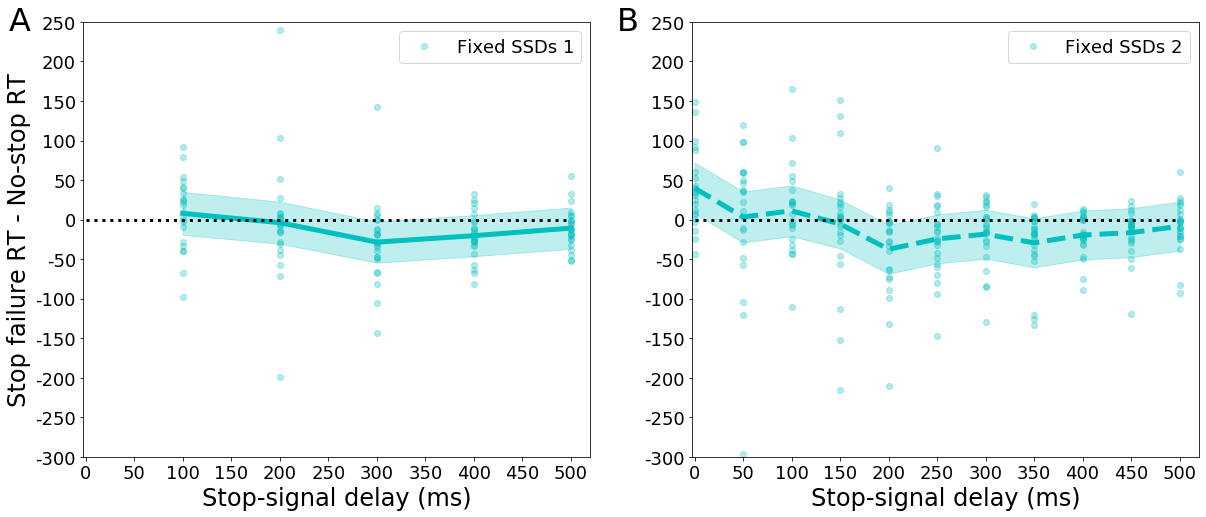

In [15]:
ci_dict = dict(zip(ind_cis.names, list(ind_cis)))

index_dict = {0: 'A',
             1: 'B'}

fig, axes = plt.subplots(1, 2, figsize=(20,8))

for idx, condition_name in enumerate(short_names[:2]):

    # get mean and confidence intervals from lmer
    ci = ci_dict[condition_name]
    
    #get individuals and bounds from violational analyses
    curr_df = pd.read_csv(f'SummaryData/summarydata{condition_name}.csv')
    pivot_df = curr_df.pivot_table(values='mean_violation', index=['ssd'],
                        columns=['subject'])
    
    #PLOT AND SAVE
    Y_LOWER = round_to_50(pivot_df.min().min())
    Y_UPPER = round_to_50(pivot_df.max().max())

    axes[idx].plot(pivot_df, linewidth=0, color=linecolors[idx], marker='o', alpha=.3) #plot individuals
    axes[idx].plot(ci['SSD_factor'].astype(int), ci.emmean,linewidth=5,  #plot mean
                 linestyle=linestyles[idx], color=linecolors[idx])
    axes[idx].fill_between(ci['SSD_factor'].astype(int), ci['lower.CL'], ci['upper.CL'], color=linecolors[idx], alpha=0.25) #plot 95% CI
    plt.axis([0,500,-300,250])
    
    #set limits
    axes[idx].axis([-3,ci['SSD_factor'].astype(int).max()+20,Y_LOWER,Y_UPPER])
    xticks=np.arange(0,pivot_df.index.max()+50,50)
    xticks = [int(i) for i in xticks]
    if len(xticks)> 16:
        xticks = [i for i in xticks if i%100==0]
    axes[idx].set_xticks(xticks)
    axes[idx].set_xticklabels(xticks,fontsize=18) 
    yticks=np.arange(-300,250+50,50)
    axes[idx].set_yticks(yticks)
    axes[idx].set_yticklabels(yticks,fontsize=18)
    axes[idx].plot([0,pivot_df.index.max()],[0,0],color='k',linestyle=':',linewidth=3)
    axes[idx].set_xlabel('Stop-signal delay (ms)',fontsize=24)
    axes[0].set_ylabel('Stop failure RT - No-stop RT',fontsize=24) #only want for A
    axes[idx].text(-0.125, 1, index_dict[idx], fontsize=32, 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=axes[idx].transAxes)
    axes[idx].legend([condition_name_dict[condition_name]], fontsize=18)
#Save
plt.savefig(path.join(FIGURE_DIR, f'Figure1.png'), bbox_inches='tight')
plt.show()
plt.close()

# __Figure 2__

## __Panel A__

In [16]:
# Getting violations for each condition
violation_by_SSD_perCondition = None
for summary_file in summary_files:
    condition_name = summary_file.replace('SummaryData/summarydata', '').replace('.csv', '') #get condition
    curr_df = pd.read_csv(summary_file)
    curr_violation_series = curr_df.groupby('ssd').mean()['mean_violation'] #get the mean violation per SSD across subjects as a pd Series
    curr_violation_series.name = condition_name #name the series after the condition
    if violation_by_SSD_perCondition is None: #create or add the series to a full DF
        violation_by_SSD_perCondition = curr_violation_series
    else:
        violation_by_SSD_perCondition = pd.concat([violation_by_SSD_perCondition,
                                                   curr_violation_series], axis=1)
violation_by_SSD_perCondition = violation_by_SSD_perCondition[short_names]

#interpolate to fill in gaps using scipy interpolate slinear
#required for Fixed SSDs 1 and Variable Difficulty conditions
violation_by_SSD_perCondition['FixedSSDs1'] = violation_by_SSD_perCondition['FixedSSDs1'].interpolate(limit_area='inside', method='slinear')
violation_by_SSD_perCondition['Matzke'] = violation_by_SSD_perCondition['Matzke'].interpolate(limit_area='inside', method='slinear')
# Drop SSDs unique to Variable Difficulty condition
non25_ssds = [i for i in violation_by_SSD_perCondition.index.astype(str) if ('33' not in i) and ('67' not in i) and (float(i) <= 800)]
violation_by_SSD_perCondition = violation_by_SSD_perCondition.loc[violation_by_SSD_perCondition.index.astype(str).isin(non25_ssds), :]

In [17]:
violation_by_SSD_perCondition_full = violation_by_SSD_perCondition.copy()
violation_by_SSD_perCondition = violation_by_SSD_perCondition.query('ssd <= 500').copy()

In [19]:
%%R -i alldata -o lmer_sum

alldata$SSD_factor = as.factor(alldata$ssd)
lmer.result <- lmer(violation ~ SSD_factor + (1|subject) + (1|study), data=alldata)
lmer_sum = summary(lmer.result)
lmer_sum

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: violation ~ SSD_factor + (1 | subject) + (1 | study)
   Data: alldata

REML criterion at convergence: 94511.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4427 -0.4705  0.0032  0.4761  8.3983 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept)  259.6   16.11   
 study    (Intercept)  352.9   18.79   
 Residual             6133.9   78.32   
Number of obs: 8159, groups:  subject, 651; study, 25

Fixed effects:
              Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)     39.551      6.380  137.573   6.199 6.20e-09 ***
SSD_factor50    -4.797      6.741 7743.017  -0.712  0.47672    
SSD_factor100  -16.841      6.281 7843.068  -2.681  0.00735 ** 
SSD_factor133  -25.364     36.672 8084.650  -0.692  0.48918    
SSD_factor150  -38.407      5.881 7929.871  -6.531 6.95e-11 ***
SSD_factor167  -28.387     25.516 7711.143  -1.113  0.26595   

R[write to console]: 
Correlation matrix not shown by default, as p = 19 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [20]:
%%R -o ci
em = emmeans(lmer.result, specs='SSD_factor') #pbkrtest.limit = 8947 - command should allow for df computation
ci = confint(em, adjust='mvt')
ci$SSD = as.numeric(levels(ci$SSD_factor))[ci$SSD_factor]
em

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8159' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8159)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8159' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8159)' or larger];
but be warned that this may result in large computation time and memory use.



 SSD_factor emmean    SE  df asymp.LCL asymp.UCL
 0           39.55  6.38 Inf     27.05     52.06
 50          34.75  6.08 Inf     22.83     46.68
 100         22.71  5.49 Inf     11.96     33.46
 133         14.19 36.47 Inf    -57.30     85.67
 150          1.14  5.01 Inf     -8.68     10.97
 167         11.16 25.23 Inf    -38.29     60.61
 200        -14.38  4.69 Inf    -23.57     -5.20
 233        -14.04 20.29 Inf    -53.82     25.73
 250        -35.21  4.63 Inf    -44.28    -26.14
 267        -60.31 19.82 Inf    -99.16    -21.46
 300        -45.84  4.63 Inf    -54.92    -36.75
 333        -40.52 18.31 Inf    -76.40     -4.63
 350        -52.83  4.75 Inf    -62.13    -43.53
 367        -67.08 17.71 Inf   -101.78    -32.38
 400        -62.56  4.91 Inf    -72.17    -52.94
 433        -66.06 18.69 Inf   -102.69    -29.43
 450        -61.68  5.20 Inf    -71.87    -51.49
 467        -60.16 19.88 Inf    -99.11    -21.20
 500        -59.05  5.51 Inf    -69.85    -48.25

Degrees-of-freedom 

In [21]:
# drop SSDs unique to Variable Difficulty condition
non25_ssds = [i for i in ci.SSD_factor.astype(str) if ('33' not in i) and ('67' not in i)]
ci = ci.loc[ci.SSD_factor.astype(str).isin(non25_ssds), :]

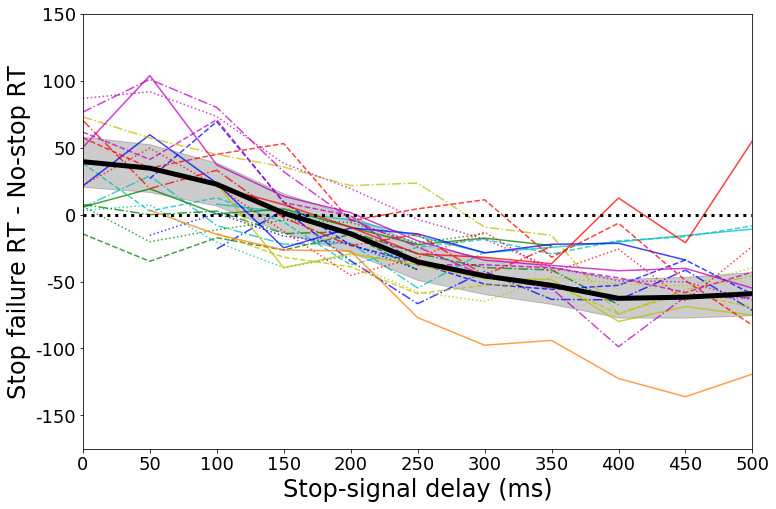

In [22]:
plt.figure(figsize=(12,8))
plt.rc('axes', prop_cycle=(cycler('color', linecolors) +
                           cycler('linestyle', linestyles)))

# plot the data
_ = plt.plot(violation_by_SSD_perCondition, alpha=0.75)
plt.plot(ci['SSD_factor'].astype(int), ci.emmean,linewidth=5, #plot mean
             linestyle='solid' ,color='k')
plt.fill_between(ci['SSD_factor'].astype(int), ci['asymp.LCL'], ci['asymp.UCL'], color='k', alpha=0.2) #plot 95% CI
plt.axis([0,500,-150,150])


#set limits
ax=plt.gca()


plt.plot([0,500],[0,0],color='k',linestyle=':',linewidth=3)
plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('Stop failure RT - No-stop RT',fontsize=24)
xticks=np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(-200,200,50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=18)
ax.set_ylim([-175, 150])
plt.show()
_ = plt.close()

## __Panel B__

In [23]:
violationCounts_by_SSD = violation_by_SSD_perCondition.copy()

In [24]:
violationCounts_by_SSD[violationCounts_by_SSD > 0] = 1 #count violations as 1, non violations as 0
violationCounts_by_SSD[violationCounts_by_SSD <= 0] = 0

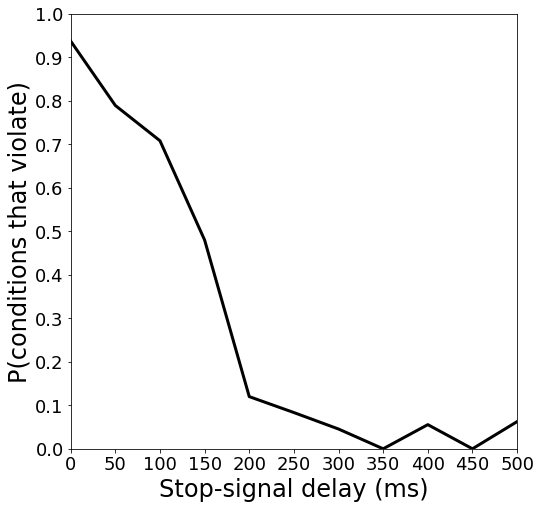

In [25]:
mean_2b = np.nanmean(violationCounts_by_SSD, axis=1)
# mean_1b.index=data_1b.loc['Task']
plt.figure(figsize=(8,8))
ax=plt.gca()
plt.axis([0,500,0,1])
plt.plot(violationCounts_by_SSD.index, mean_2b,linewidth=3,color='k')
xticks=np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,1.1,0.1)
ax.set_yticks(yticks)
ax.set_yticklabels(['%0.1f'%i for i in yticks],fontsize=18)
plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('P(conditions that violate)',fontsize=24)
plt.show()
_ = plt.close()

## __Panel C__

In [26]:
proportionSubjectsViolating_per_SSD = None
for summary_file in summary_files:
    condition_name = summary_file.replace('SummaryData/summarydata', '').replace('.csv', '') #get condition
    curr_df = pd.read_csv(summary_file)
    curr_df['violation_count'] = 0
    curr_df.loc[curr_df['mean_violation']>0, 'violation_count'] = 1
    violations_per_SSD = curr_df.groupby('ssd').sum()['violation_count']
    num_subjs_per_SSD = curr_df.groupby('ssd').count()['subject']
    prop_violations  = violations_per_SSD / num_subjs_per_SSD
    prop_violations.name = condition_name #name the series after the condition
    if proportionSubjectsViolating_per_SSD is None: #create or add the series to a full DF
        proportionSubjectsViolating_per_SSD = prop_violations
    else:
        proportionSubjectsViolating_per_SSD = pd.concat([proportionSubjectsViolating_per_SSD,
                                                   prop_violations], axis=1)
proportionSubjectsViolating_per_SSD = proportionSubjectsViolating_per_SSD[short_names]

#interpolate to fill in gaps using scipy interpolate slinear
#required for Fixed SSDs 1 and Variable Difficulty conditions
proportionSubjectsViolating_per_SSD['FixedSSDs1'] = proportionSubjectsViolating_per_SSD['FixedSSDs1'].interpolate(limit_area='inside', method='slinear')
proportionSubjectsViolating_per_SSD['Matzke'] = proportionSubjectsViolating_per_SSD['Matzke'].interpolate(limit_area='inside', method='slinear')
# Drop SSDs unique to Variable Difficulty condition
non25_ssds = [i for i in proportionSubjectsViolating_per_SSD.index.astype(str) if ('33' not in i) and ('67' not in i) and (float(i) <= 800)]
proportionSubjectsViolating_per_SSD = proportionSubjectsViolating_per_SSD.loc[proportionSubjectsViolating_per_SSD.index.astype(str).isin(non25_ssds), :]

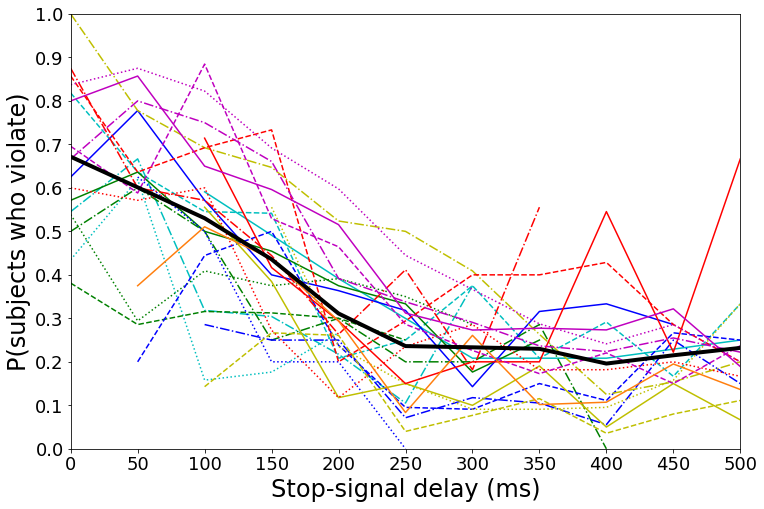

In [27]:
plt.figure(figsize=(12,8))
plt.rc('axes', prop_cycle=(cycler('color', linecolors) +
                           cycler('linestyle', linestyles)))


# plot the data
plt.plot(proportionSubjectsViolating_per_SSD)
# plot mean

plt.plot(proportionSubjectsViolating_per_SSD.mean(1),linewidth=4,color='k', linestyle='solid')
plt.axis([0,500,0,1])

ax=plt.gca()


plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('P(subjects who violate)',fontsize=24)
xticks=np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,1.1,0.1)
ax.set_yticks(yticks)
ax.set_yticklabels(['%0.1f'%i for i in yticks],fontsize=18)
plt.show()
_ = plt.close()

## __Panel D__

In [28]:
cumulativeStopTrials_per_ssd = None
for data_file in data_files:
    condition_name = data_file.replace('Data/Data', '').replace('.xlsx', '') #get condition
    curr_df = pd.read_excel(data_file)
    nstoptrials_per_ssd = curr_df.groupby('StopSignalDelay').count()['Subject'] #sum num stop trials across subjects at each SSD
    nstoptrials_per_ssd = nstoptrials_per_ssd.drop(labels=['?']) #drop non stop trials
    cumulative_percentages_per_ssd = nstoptrials_per_ssd.cumsum() / nstoptrials_per_ssd.sum() #take the cumulativesum / total
    cumulative_percentages_per_ssd.name = condition_name #name the series after the condition
    if cumulativeStopTrials_per_ssd is None: #create or add the series to a full DF
        cumulativeStopTrials_per_ssd = cumulative_percentages_per_ssd
    else:
        cumulativeStopTrials_per_ssd = pd.concat([cumulativeStopTrials_per_ssd,
                                                   cumulative_percentages_per_ssd], axis=1, sort=True)
cumulativeStopTrials_per_ssd = cumulativeStopTrials_per_ssd[short_names]  
#interpolate to fill in gaps using scipy interpolate slinear
cumulativeStopTrials_per_ssd = cumulativeStopTrials_per_ssd.set_index(cumulativeStopTrials_per_ssd.index.astype('float')) #convert index to float for interpolation
#required for Fixed SSDs 1 and Variable Difficulty conditions
cumulativeStopTrials_per_ssd['FixedSSDs1'] = cumulativeStopTrials_per_ssd['FixedSSDs1'].interpolate(limit_area='inside', method='slinear')
cumulativeStopTrials_per_ssd['Matzke'] = cumulativeStopTrials_per_ssd['Matzke'].interpolate(limit_area='inside', method='slinear')
# Drop SSDs unique to Variable Difficulty condition
non25_ssds = [i for i in cumulativeStopTrials_per_ssd.index.astype(str) if ('33' not in i) and ('67' not in i) and (float(i) <= 800)]
cumulativeStopTrials_per_ssd = cumulativeStopTrials_per_ssd.loc[cumulativeStopTrials_per_ssd.index.astype(str).isin(non25_ssds), :]

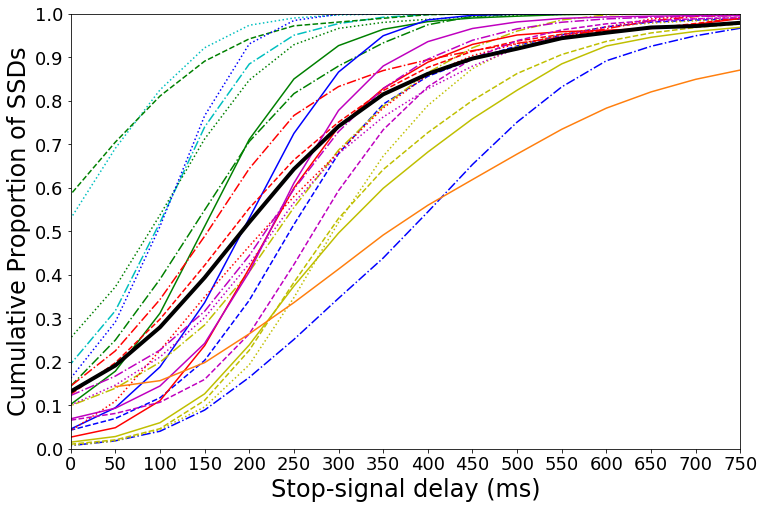

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
# iterate over conditions, keeping color and marker order
for idx, col in enumerate(cumulativeStopTrials_per_ssd.columns):
    if 'Fixed' not in col:
        ax.plot(cumulativeStopTrials_per_ssd[col],
                linestyle=linestyles[idx], color=linecolors[idx])

# delete non-tracking SSDs before meaning
del cumulativeStopTrials_per_ssd['FixedSSDs1']
del cumulativeStopTrials_per_ssd['FixedSSDs2']

# plot the data
plt.axis([0,750,0,1])
# plot mean
ax.plot(cumulativeStopTrials_per_ssd.mean(1),linewidth=4,color='k', linestyle='solid')

plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('Cumulative Proportion of SSDs',fontsize=24)
xticks=np.arange(0,800,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,1.01,.1)
ax.set_yticks(yticks)
ax.set_yticklabels(['%0.1f'%i for i in yticks],fontsize=18)
plt.show()
_ = plt.close()

## __Combine & Save__

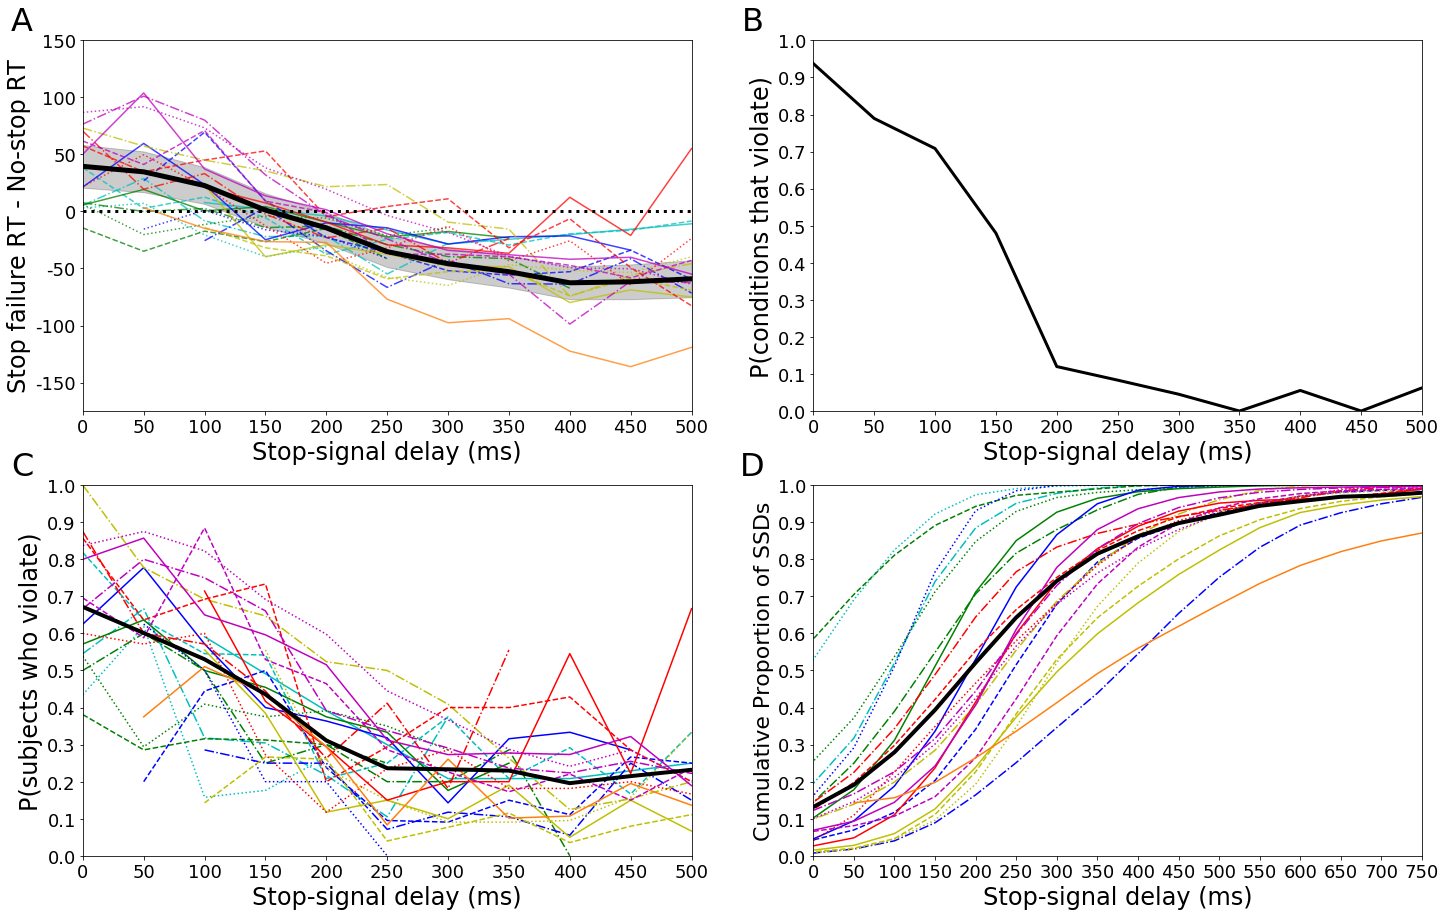

In [30]:
fig, axes = plt.subplots(2,2, figsize=(24,15))

# Panel A
plt.rc('axes', prop_cycle=(cycler('color', linecolors) +
                           cycler('linestyle', linestyles)))

# plot the data
axes[0,0].plot(violation_by_SSD_perCondition, alpha=0.75)
axes[0,0].plot(ci['SSD_factor'].astype(int), ci.emmean,linewidth=5, #plot mean
             linestyle='solid' ,color='k')
axes[0,0].fill_between(ci['SSD_factor'].astype(int), ci['asymp.LCL'], ci['asymp.UCL'], color='k', alpha=0.2) #plot 95% CI
axes[0,0].axis([0,500,-150,150])
axes[0,0].plot([0,500],[0,0],color='k',linestyle=':',linewidth=3)
axes[0,0].set_xlabel('Stop-signal delay (ms)',fontsize=24)
axes[0,0].set_ylabel('Stop failure RT - No-stop RT',fontsize=24)
xticks=np.arange(0,550,50)
axes[0,0].set_xticks(xticks)
axes[0,0].set_xticklabels(xticks,fontsize=18)
yticks=np.arange(-200,200,50)
axes[0,0].set_yticks(yticks)
axes[0,0].set_yticklabels(yticks,fontsize=18)
axes[0,0].set_ylim([-175, 150])
axes[0,0].text(-0.1, 1.05, 'A', fontsize=32, 
               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[0,0].transAxes)


# Panel B
axes[0,1].plot(violationCounts_by_SSD.index, mean_2b,linewidth=3,color='k')
axes[0,1].axis([0,500,0,1])
xticks=np.arange(0,550,50)
axes[0,1].set_xticks(xticks)
axes[0,1].set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,1.1,0.1)
axes[0,1].set_yticks(yticks)
axes[0,1].set_yticklabels(['%0.1f'%i for i in yticks],fontsize=18)
axes[0,1].set_xlabel('Stop-signal delay (ms)',fontsize=24)
axes[0,1].set_ylabel('P(conditions that violate)',fontsize=24)
axes[0,1].text(-0.1, 1.05, 'B', fontsize=32, 
               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[0,1].transAxes)


# Panel C
axes[1,0].plot(proportionSubjectsViolating_per_SSD)
axes[1,0].plot(proportionSubjectsViolating_per_SSD.mean(1),linewidth=4,color='k', linestyle='solid')
#make pretty
axes[1,0].axis([0,500,0,1])
axes[1,0].set_xlabel('Stop-signal delay (ms)',fontsize=24)
axes[1,0].set_ylabel('P(subjects who violate)',fontsize=24)
xticks=np.arange(0,550,50)
axes[1,0].set_xticks(xticks)
axes[1,0].set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,1.1,0.1)
axes[1,0].set_yticks(yticks)
axes[1,0].set_yticklabels(['%0.1f'%i for i in yticks],fontsize=18)
axes[1,0].text(-0.1, 1.05, 'C', fontsize=32, 
               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[1,0].transAxes)

# Panel D
# iterate over conditions, keeping color and marker order
for idx, col in enumerate(cumulativeStopTrials_per_ssd.columns):
    idx += 2
    axes[1,1].plot(cumulativeStopTrials_per_ssd[col],
            linestyle=linestyles[idx], color=linecolors[idx])

# plot the data
axes[1,1].axis([0,750,0,1])
# plot mean
axes[1,1].plot(cumulativeStopTrials_per_ssd.mean(1),linewidth=4,color='k', linestyle='solid')

axes[1,1].set_xlabel('Stop-signal delay (ms)',fontsize=24)
axes[1,1].set_ylabel('Cumulative Proportion of SSDs',fontsize=22)
xticks=np.arange(0,800,50)
axes[1,1].set_xticks(xticks)
axes[1,1].set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,1.01,.1)
axes[1,1].set_yticks(yticks)
axes[1,1].set_yticklabels(['%0.1f'%i for i in yticks],fontsize=18)
axes[1,1].text(-0.1, 1.05, 'D', fontsize=32, 
               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[1,1].transAxes)

# Save
plt.savefig(path.join(FIGURE_DIR, 'Figure2.png'), bbox_inches='tight')
plt.show()
_ = plt.close()

# __Figure 3__

## __Panel A__

In [31]:
# for each condition, get a mean SSRT using all SSDs, and only using SSDs >= 200ms
condition_order = []
SSRTs_per_condition = []
SSRTs_longSSDs_per_condition = []

for data_file in data_files:
    condition_name=data_file.replace('Data/Data', '').replace('.xlsx', '') #get condition
    cond_df = read_cond_file(data_file)
    cond_SSRTs,SSRTs_longSSDS = ssrt_fulllong(cond_df, verbose=False)
    
    condition_order.append(condition_name)
    SSRTs_per_condition.append(np.asarray(cond_SSRTs))
    SSRTs_longSSDs_per_condition.append(np.asarray(SSRTs_longSSDS))
    
# Get mean SSRT (full and long SSDs) for each condition 
meanSSRTs_per_condition = [np.nanmean(cond_SSRTs) for cond_SSRTs in list(SSRTs_per_condition)]
meanSSRTs_longSSDs_per_condition = [np.nanmean(cond_SSRTs) for cond_SSRTs in list(SSRTs_longSSDs_per_condition)]


#build up dictionary - k,v = condition_name, [full SSDs SSRT, long SSDs SSRT] - to be converted into df
data2c_dict = {}
for idx, condition in enumerate(condition_order):
    data2c_dict[condition] = [meanSSRTs_per_condition[idx], meanSSRTs_longSSDs_per_condition[idx]]

# transform into DF
data2c_df = pd.DataFrame(data2c_dict)
data2c_df = data2c_df[short_names] # reorder for consistent order across figures


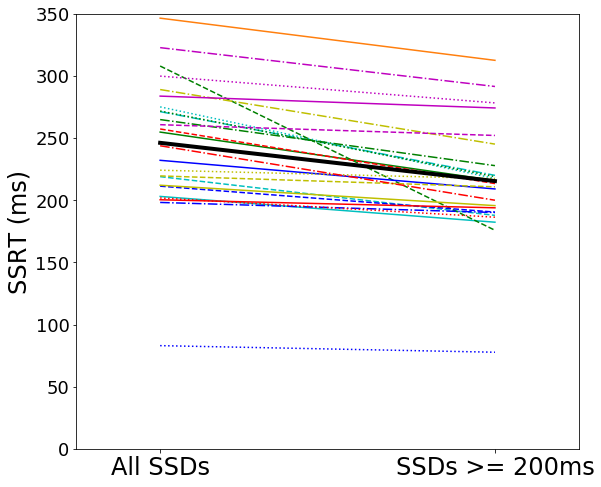

In [32]:
#PLOT
plt.figure(figsize=(9,8))
plt.rc('axes', prop_cycle=(cycler('color', linecolors) +
                           cycler('linestyle', linestyles)))

# plot the data
plt.plot(data2c_df)

plt.axis([-0.25,1.25, 0, 350]) # previously [.75,2.25, 0,350]

# plot mean
plt.plot(data2c_df.mean(1),linewidth=4,color='k', linestyle='solid')

# Add the patch to the Axes
ax=plt.gca()

# plt.xlabel('All SSDs                           SSDs >= 200ms',fontsize=24)
plt.ylabel('SSRT (ms)',fontsize=24)
ax.set_xticks([0, 1])
ax.set_xticklabels(['All SSDs', 'SSDs >= 200ms'], fontsize=24)

yticks=np.arange(0,400,50) #previously np.arange(0,400,50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=18)

plt.show()
_ = plt.close()

## __Panel B__

In [33]:
# Get and clean data for conditions 11 and 12
cond11_df = read_cond_file('Data/DataTurkSimpleLow.xlsx')
cond12_df = read_cond_file('Data/DataTurkSimpleHigh.xlsx')

In [34]:
# Collect SSRTs and SSDs for each subject
SSRTs_low = []
SSDs_low = []
for subject in full_passed_turkers:
    subj_df = cond11_df.query('Subject == %d' % subject).copy()
    SSRT, mean_SSD = calc_SSRT(subj_df, method='replacement')
    SSRTs_low.append(SSRT)
    SSDs_low.append(mean_SSD)
    
SSRTs_high = []
SSDs_high = []
for subject in full_passed_turkers:
    subj_df = cond12_df.query('Subject == %d' % subject).copy()
    SSRT, mean_SSD = calc_SSRT(subj_df,  method='replacement')
    SSRTs_high.append(SSRT)
    SSDs_high.append(mean_SSD)
    
# build up dataframe for figure 2a
fig2a_df = pd.DataFrame({'SSRTHigh': SSRTs_high, 'SSRTLow': SSRTs_low}, index=full_passed_turkers)

above_subjects = np.asarray(full_passed_turkers)[(np.asarray(SSDs_low) > 300) & (np.asarray(SSDs_high) > 300)]
below_subjects = np.asarray(full_passed_turkers)[(np.asarray(SSDs_low) < 300) & (np.asarray(SSDs_high) < 300)]


fig2a_df['MeanSSDBelowOrAbove300'] = np.nan
fig2a_df.loc[above_subjects, 'MeanSSDBelowOrAbove300'] = 'Above'
fig2a_df.loc[below_subjects, 'MeanSSDBelowOrAbove300'] = 'Below'
fig2a_df['subject'] = full_passed_turkers


fig2a_df = fig2a_df.dropna()
fig2a_df = fig2a_df.sort_values(by=['MeanSSDBelowOrAbove300'],  ascending=False)

print(f'{len(below_subjects)} subjects kept in the short SSD condition')
print(f'{len(above_subjects)} subjects kept in the long SSD condition')

# Tidy up dataframe for data presentation
data_2a_tidy = fig2a_df.melt(id_vars=['subject', 'MeanSSDBelowOrAbove300'],
                            value_vars=['SSRTLow','SSRTHigh'],
                            var_name='% of stop signals', 
                            value_name='Stop Signal Reaction Time (ms)')
data_2a_tidy = data_2a_tidy.replace({'SSRTLow':'20%',
                                     'SSRTHigh':'40%',
                                    'Below':'Mean SSD < 300 ms',
                                    'Above':'Mean SSD > 300 ms'})

136 subjects kept in the short SSD condition
88 subjects kept in the long SSD condition


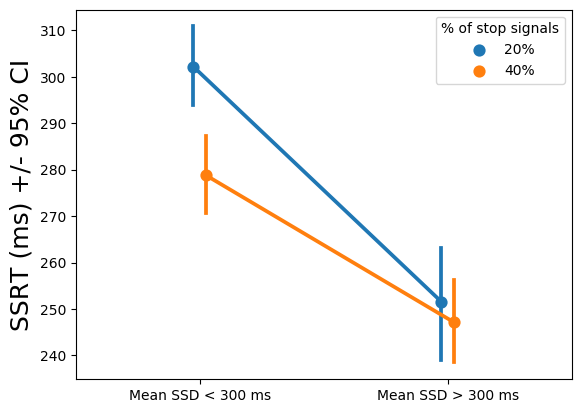

In [35]:
#plot
matplotlib.style.use('default') # RESET COLOR CYCLE
sns.pointplot(x='MeanSSDBelowOrAbove300',
                  y='Stop Signal Reaction Time (ms)',
                  hue='% of stop signals',
                  data=data_2a_tidy,
                  dodge=True)

plt.xlabel('')
plt.ylabel('SSRT (ms) +/- 95% CI',fontsize=18)
plt.show()
_ = plt.close()

## __Panel C__

In [36]:
# Load in data
cond20_df = read_cond_file('Data/DataBtwnSubjStimSelec.xlsx')

In [37]:
####################################################################################################
# For each subject, classify them as SD or DDS
# Using bayesfactor as done in the original paper (which used http://pcl.missouri.edu/bf-two-sample)

#ORIGINAL LABELS - Used for comparison
strat_dict_og = {
    1: 'SD',
    2: 'DDS',
    3: 'DDS',
    4: 'SD',
    5: 'SD',
    6: 'DDS',
    7: 'DDS',
    8: 'SD',
    9: 'DDS',
    10: 'DDS',
    11: 'DDS',
    12: 'DDS',
    13: 'SD',
    14: 'DDS',
    15: 'DDS', #will be dropped for missing vals
    16: 'SD',  #will be dropped for missing vals
    17: 'DDS',
    18: 'SD',
    19: 'DDS',
    20: 'SD',
    21: 'DDS',
    22: 'DDS',
    23: 'DDS',
    24: 'DDS'
    
}

#Compute labels
strat_dict = {}

for subject in cond20_df.Subject.unique():
    subdata = cond20_df.query('Subject == %d' % subject).copy()
    # Get distribution of goRTs, signalRespondRTs, and ignoreRTs for t-tests and subsequent BayeFactor
    goRTs = subdata.loc[(subdata['TrialType']=='go') & (subdata['GoRT']>0), 'GoRT'].values.copy()
    signalRespondRTs = subdata.loc[(subdata['TrialType']=='stop') & (subdata['StopFailureRT']>0), 'StopFailureRT'].values.copy()
    ignoreRTs = subdata.loc[(subdata['TrialType']=='ignore') & (subdata['IgnoreRT']>0), 'IgnoreRT'].values.copy()
    
    # stopfail vs go
    t_signalRespond_v_noSignal, _ = stats.ttest_ind(signalRespondRTs, goRTs)
    bayes_out_signalRespond = BayesFactor.ttest_tstat(t=float(t_signalRespond_v_noSignal),
                                                  n1=len(signalRespondRTs),
                                                  n2=len(goRTs), rscale = 1) #using 1 as in the 2014 paper
    bf_signalRespond = math.exp(get_attr(bayes_out_signalRespond))
    
    # ignore vs go
    t_ignore_v_noSignal, _ = stats.ttest_ind(ignoreRTs, goRTs)
    bayes_out_ignore = BayesFactor.ttest_tstat(t=float(t_ignore_v_noSignal),
                                                      n1=len(ignoreRTs),
                                                      n2=len(goRTs), rscale = 1) #using 1 as in the 2014 paper
    bf_ignore = math.exp(get_attr(bayes_out_ignore))
    
    #label - criteria is bf >1 + direction is correct (bf is not directional)
    if (np.abs(bf_ignore) > 1) & (np.mean(ignoreRTs)>np.mean(goRTs)):
        if (np.abs(bf_signalRespond) > 1) & (np.mean(goRTs)>np.mean(signalRespondRTs)): 
            strat_dict[subject] = 'SD'
        else:
            strat_dict[subject] = 'DDS'
    else:
        strat_dict[subject] = 'uncategorized/IDS'
    



set1 = set(strat_dict_og.items())
set2 = set(strat_dict.items())
print('Difference between original and new strategy labels:', set1 ^ set2)

R[write to console]: t is large; approximation invoked.



Difference between original and new strategy labels: set()


In [38]:
###################################################################################################
# Generate a DF that has every stop trial which had a previous Go trial, contains the previous goRT
verbose = False
go_key = 'GoRT'


stop_trials_w_matchingGo = None
for subject in cond20_df.Subject.unique():
    subdata = cond20_df.query('Subject == %d' % subject).copy()
    if verbose: print('subject %d: found %d trials' % (subject, subdata.shape[0]))
    ssdvals = [i for i in subdata.StopSignalDelay.unique() if isinstance(i, float) and i >=0] #ignore nan/missing values and 0/negative SSDs
    ssdvals.sort()

    # You find all pairs of trials in which the first is a go trials with a response and the second is a 
    # stop trial with a response. Both trials need to come from the same subject and block. 
    # This should be done separately for each SSD. Then the RT for the first trial in the pair should be 
    # subtracted from the second. This is the core analysis per SSD per subject.

    for ssd in ssdvals:
        ssd_data = subdata.query('StopSignalDelay == %d' % ssd).copy()
        signal_respond_data = ssd_data.dropna(subset=["StopFailureRT"])
        signal_respond_data = signal_respond_data.loc[signal_respond_data['StopFailureRT'] > 0, :]
        # for each signal respond trial, determine whether the previous trial was a go trial in the same block
        signal_respond_data['MatchingGo'] = np.nan
        if signal_respond_data.shape[0] > 0:
            for t in signal_respond_data.index:
                if t < 1:
                    continue
                prevtrial = cond20_df.loc[int(t) - 1, :]
                if prevtrial.Block == signal_respond_data.loc[t, 'Block']:
                    # blockmatch
                    signal_respond_data.loc[t, 'MatchingGo'] = prevtrial[go_key]
            signal_respond_data = signal_respond_data.dropna(subset=['MatchingGo'])
            if stop_trials_w_matchingGo is None:
                stop_trials_w_matchingGo = signal_respond_data
            else:
                stop_trials_w_matchingGo = pd.concat([stop_trials_w_matchingGo, signal_respond_data], axis=0)

In [39]:
#Build up pertinent data for each subject: StopFailRTAtShorterSSDs, StopFailRTAtLongerSSDs, PrecedingNoStopRTAtShorterSSDs, PrecedingNoStopRTAtLongerSSDs
stopFailRTs_shortSSDs = []
stopFailRTs_longSSDs = []
precedingNoStopRTs_shortSSDs = []
precedingNoStopRTs_longSSDs = []

for subject in cond20_df.Subject.unique():
    subdata = stop_trials_w_matchingGo.query('Subject == %d' % subject).copy()
    
    shortSSD_df = subdata.loc[subdata.StopSignalDelay<250]
    stopFailRTs_shortSSDs.append(shortSSD_df['StopFailureRT'].mean())
    precedingNoStopRTs_shortSSDs.append(shortSSD_df['MatchingGo'].mean())
    
    longSSD_df = subdata.loc[subdata.StopSignalDelay>250]
    stopFailRTs_longSSDs.append(longSSD_df['StopFailureRT'].mean())
    precedingNoStopRTs_longSSDs.append(longSSD_df['MatchingGo'].mean())

In [40]:
#Combine into a single df
fig2b_df = pd.DataFrame({'Subject': cond20_df.Subject.unique(), 'Strategy': [strat_dict[sub] for sub in cond20_df.Subject.unique()], 'StopFailRTAtShorterSSDs': stopFailRTs_shortSSDs,
                        'StopFailRTAtLongerSSDs': stopFailRTs_longSSDs, 'PrecedingNoStopRTAtShorterSSDs': precedingNoStopRTs_shortSSDs, 
                        'PrecedingNoStopRTAtLongerSSDs': precedingNoStopRTs_longSSDs})
fig2b_df = fig2b_df.sort_values(by=['Strategy'], ascending=False)
fig2b_df = fig2b_df.dropna() # 2 subjects were identified as having nans - 15 &16

data_2b = fig2b_df.replace({'below':'Mean SSD < 250 ms',
                                    'above':'Mean SSD > 250 ms'})

data_2b_tidy=fig2b_df.melt(id_vars='Strategy',
                            value_vars=['StopFailRTAtShorterSSDs', 
                                        'StopFailRTAtLongerSSDs',
                                        'PrecedingNoStopRTAtShorterSSDs', 
                                        'PrecedingNoStopRTAtLongerSSDs'],
                            var_name='SSD', 
                            value_name='Reaction time (ms)')
data_2b_tidy['Type']=data_2b_tidy['SSD']
data_2b_tidy['ShortLong']=data_2b_tidy['SSD']


data_2b_tidy.loc[data_2b_tidy['SSD']=='PrecedingNoStopRTAtLongerSSDs','ShortLong']='Mean SSD > 250 ms'
data_2b_tidy.loc[data_2b_tidy['SSD']=='StopFailRTAtLongerSSDs','ShortLong']='Mean SSD > 250 ms'
data_2b_tidy.loc[data_2b_tidy['SSD']=='PrecedingNoStopRTAtShorterSSDs','ShortLong']='Mean SSD < 250 ms'
data_2b_tidy.loc[data_2b_tidy['SSD']=='StopFailRTAtShorterSSDs','ShortLong']='Mean SSD < 250 ms'

data_2b_tidy.loc[data_2b_tidy['SSD']=='PrecedingNoStopRTAtLongerSSDs','Type']='PrecedingNoStop'
data_2b_tidy.loc[data_2b_tidy['SSD']=='StopFailRTAtLongerSSDs','Type']='StopFail'
data_2b_tidy.loc[data_2b_tidy['SSD']=='PrecedingNoStopRTAtShorterSSDs','Type']='PrecedingNoStop'
data_2b_tidy.loc[data_2b_tidy['SSD']=='StopFailRTAtShorterSSDs','Type']='StopFail'


del data_2b_tidy['SSD']


ViolationShortSSD=fig2b_df['PrecedingNoStopRTAtShorterSSDs']-fig2b_df['StopFailRTAtShorterSSDs']
ViolationLongSSD=fig2b_df['PrecedingNoStopRTAtLongerSSDs']-fig2b_df['StopFailRTAtLongerSSDs']

data_2b_violation=fig2b_df.assign(ViolationShortSSD=ViolationShortSSD,
                                ViolationLongSSD=ViolationLongSSD)
for i in ['StopFailRTAtShorterSSDs', 'StopFailRTAtLongerSSDs',
       'PrecedingNoStopRTAtShorterSSDs', 'PrecedingNoStopRTAtLongerSSDs']:
    del data_2b_violation[i]
    
data_2b_violation_tidy=data_2b_violation.melt(id_vars='Strategy',
                            value_vars=['ViolationShortSSD','ViolationLongSSD'],
                            var_name='SSD', 
                            value_name='No-stop RT - Stop failure RT')

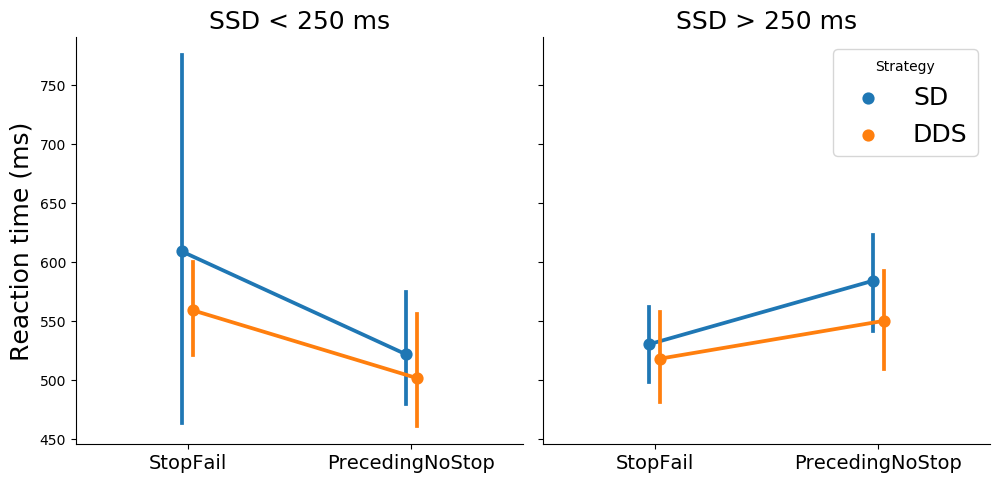

In [41]:
fig=sns.catplot(x='Type',
                  y='Reaction time (ms)',
                  col='ShortLong',hue='Strategy',
                  kind='point',
                  data=data_2b_tidy,dodge=True,legend=False)
fig.axes[0][0].set_ylabel('Reaction time (ms)',size=18)
fig.axes[0][0].set_xlabel('')
fig.axes[0][1].set_xlabel('')

fig.axes[0][0].set_xticklabels(fig.axes[0][0].get_xticklabels(),fontsize=14)
fig.axes[0][1].set_xticklabels(fig.axes[0][1].get_xticklabels(),fontsize=14)


fig.axes[0][0].set_title('SSD < 250 ms',fontsize=18)
fig.axes[0][1].set_title('SSD > 250 ms',fontsize=18)

plt.legend(fontsize=18,title='Strategy')
plt.show()
_ = plt.close()

## __Combine & Save__

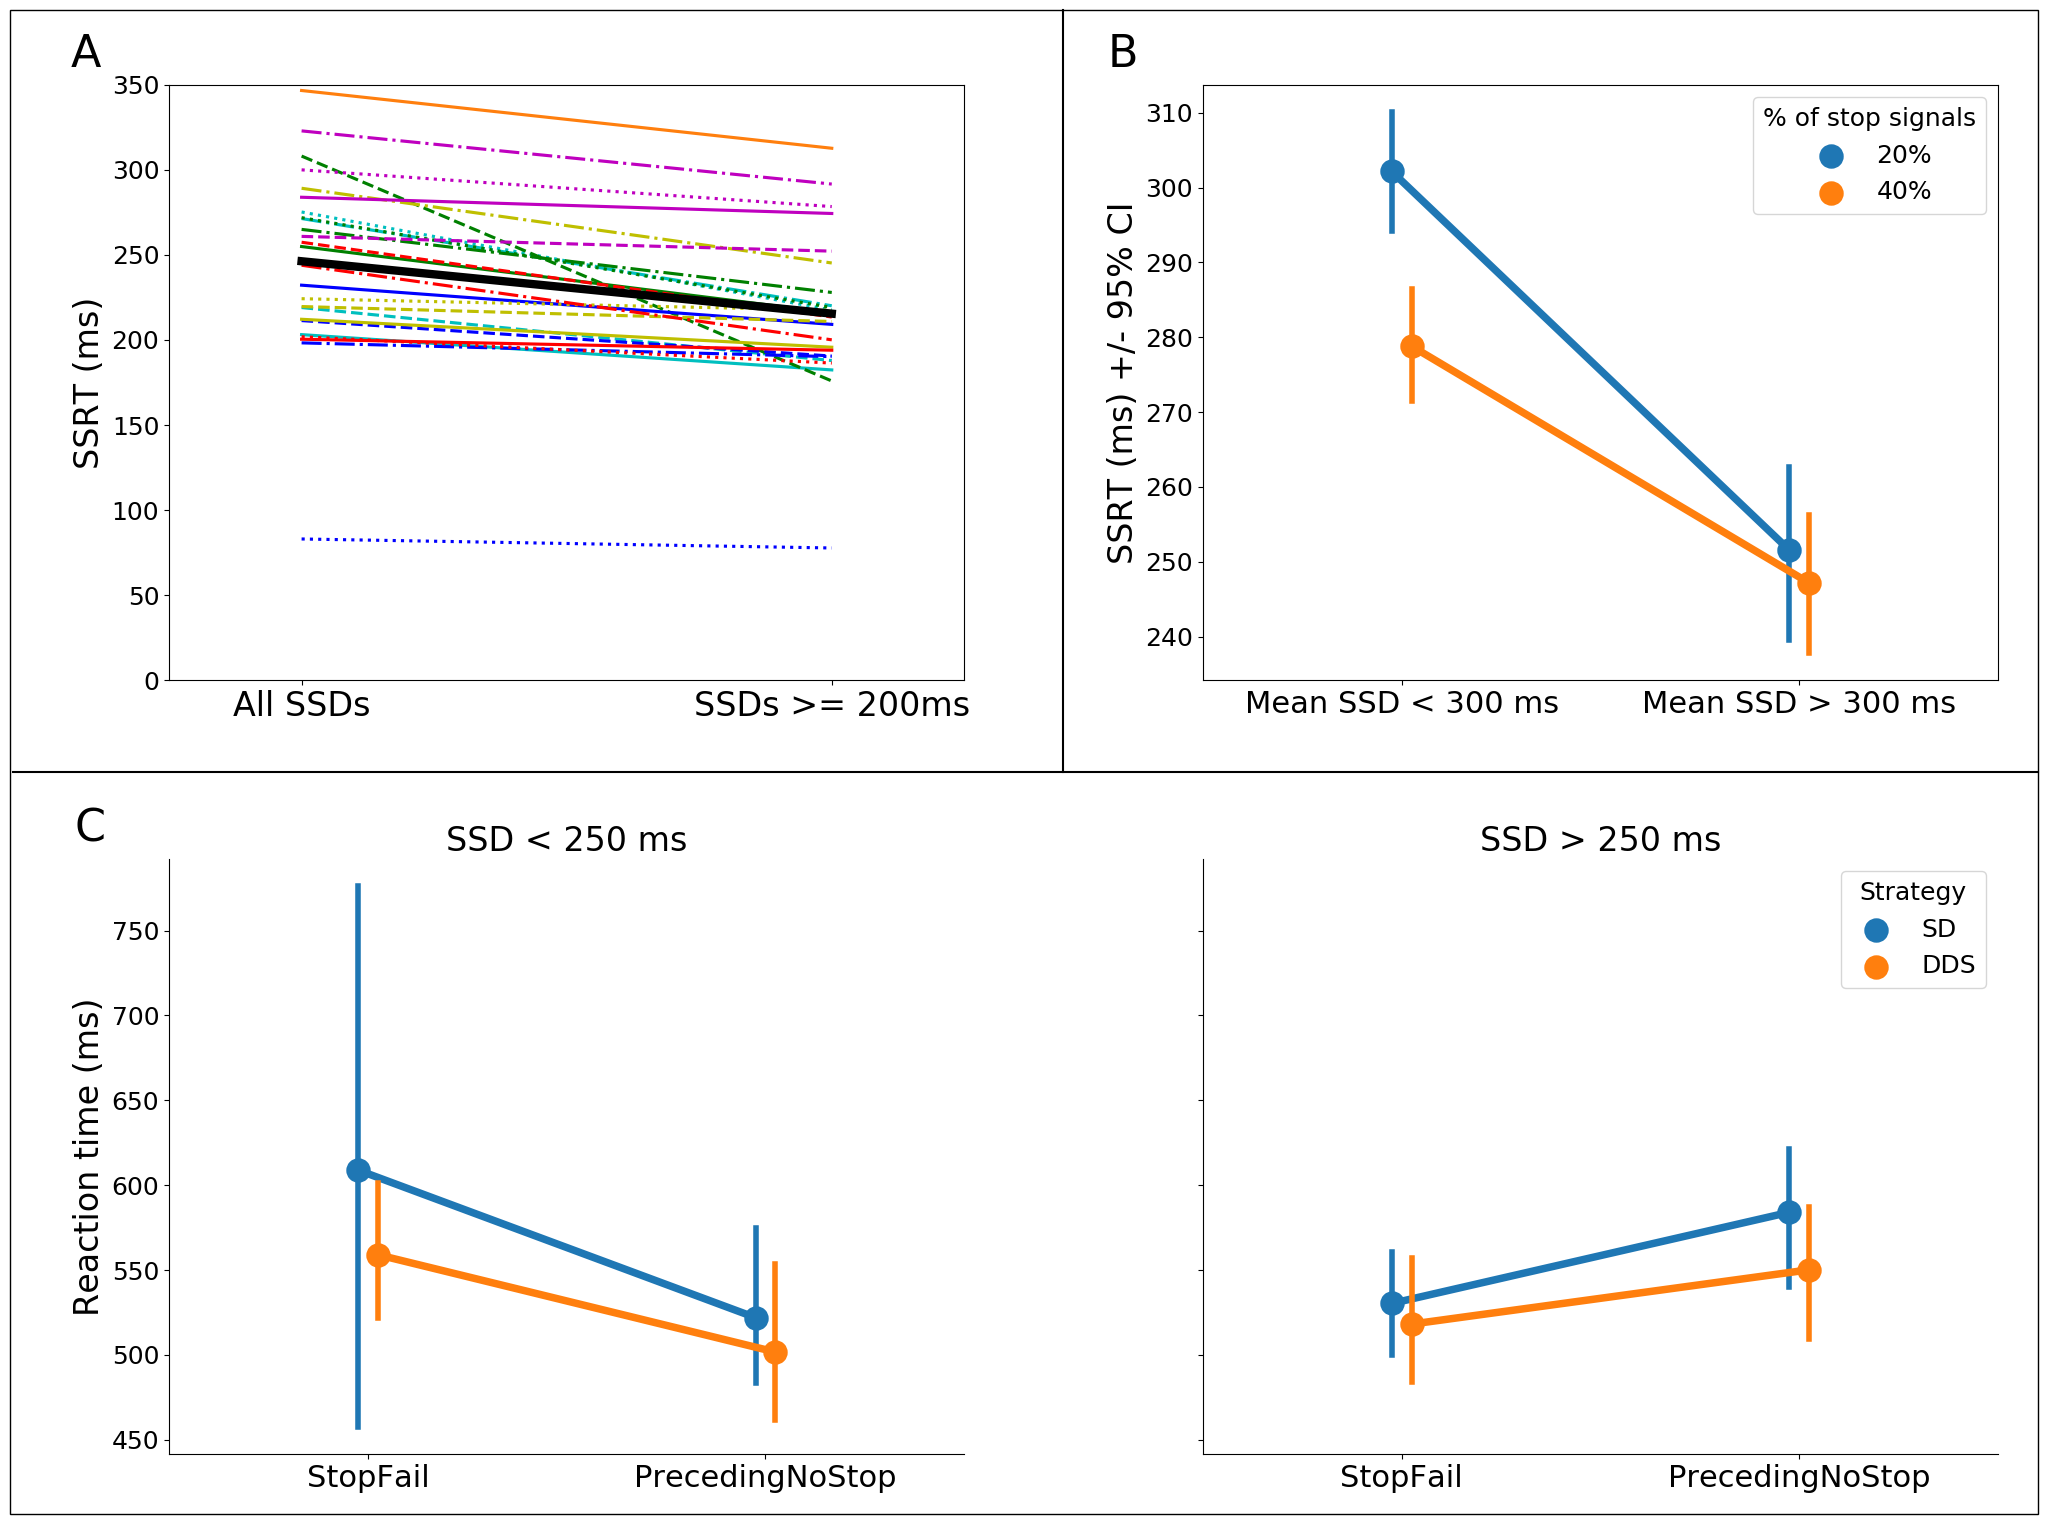

In [42]:
fig, axes = plt.subplots(2,2, figsize=(20,15)) 


# Panel A
axes[0,0].set_prop_cycle(color=linecolors, linestyle=linestyles)
axes[0,0].plot(data2c_df, linewidth=2.25)
# plot mean
axes[0,0].plot(data2c_df.mean(1),linewidth=6,color='k', linestyle='solid')

axes[0,0].axis([-0.25,1.25, 0, 350])

axes[0,0].set_ylabel('SSRT (ms)',fontsize=24)
axes[0,0].set_xticks([0, 1])
axes[0,0].set_xticklabels(['All SSDs', 'SSDs >= 200ms'], fontsize=24)

yticks=np.arange(0,400,50)
axes[0,0].set_yticks(yticks)
axes[0,0].set_yticklabels(yticks,fontsize=18)
axes[0,0].text(-0.105, 1.05, 'A', fontsize=32, 
               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[0,0].transAxes)


# Panel B
matplotlib.style.use('default') # RESET COLOR CYCLE

axes[0,1].set_prop_cycle(color=linecolors)
sns.pointplot(x='MeanSSDBelowOrAbove300',
                  y='Stop Signal Reaction Time (ms)',
                  hue='% of stop signals',
                  data=data_2a_tidy,
                  dodge=True, ax=axes[0,1],
              scale=2,
              errwidth=4,
             fontsize=24)

axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('SSRT (ms) +/- 95% CI',fontsize=24)
axes[0,1].set_yticklabels([int(i) for i in axes[0,1].get_yticks()], fontsize=18)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(),fontsize=22)
leg = axes[0][1].legend(fontsize=18)
leg.set_title('% of stop signals',prop={'size':18})
axes[0,1].text(-0.1, 1.05, 'B', fontsize=32, 
               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[0,1].transAxes)


# Panel C
axes[1,0].set_prop_cycle(color=linecolors)
sns.pointplot(x='Type',
                  y='Reaction time (ms)',
                 hue='Strategy',
                  kind='point',
                  data=data_2b_tidy.loc[data_2b_tidy.ShortLong=='Mean SSD < 250 ms'],
                 dodge=True,legend=False,
                  ax=axes[1,0],
              scale=2,
              errwidth=4,
             size=6)

axes[1,1].set_prop_cycle(color=linecolors)
sns.pointplot(x='Type',
                  y='Reaction time (ms)',
                 hue='Strategy',
                  kind='point',
                  data=data_2b_tidy.loc[data_2b_tidy.ShortLong=='Mean SSD > 250 ms'],
                 dodge=True,legend=False,
                  ax=axes[1,1],
              scale=2,
              errwidth=4,
             size=6)

axes[1][0].set_ylabel('Reaction time (ms)',size=24)
# Hide the right and top spines
axes[1][0].spines['right'].set_visible(False)
axes[1][0].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)
axes[1][1].spines['top'].set_visible(False)
axes[1][0].set_xlabel('')
axes[1][1].set_xlabel('')
axes[1][1].set_ylabel('')
axes[1][0].set_yticklabels([int(i) for i in axes[1][0].get_yticks()], fontsize=18)



axes[1][1].set_yticklabels('')
axes[1][1].set_ylim(axes[1][0].get_ylim())

axes[1][0].set_xticklabels(axes[1][0].get_xticklabels(),fontsize=22)
axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(),fontsize=22)


axes[1][0].set_title('SSD < 250 ms',fontsize=24)
axes[1][1].set_title('SSD > 250 ms',fontsize=24)

axes[1][0].get_legend().remove()
leg = axes[1][1].legend(fontsize=18)
leg.set_title('Strategy',prop={'size':18})


axes[1,0].text(-0.1, 1.05, 'C', fontsize=32, 
               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[1,0].transAxes)


# border
autoAxis = axes[1,0].axis()
rec = Rectangle((-.2,-.1),2.55,2.525,fill=False,lw=1,
               transform=axes[1,0].transAxes)

rec = axes[1,0].add_patch(rec)
rec.set_clip_on(False)

# rearange the axes for no overlap
fig.tight_layout()
plt.subplots_adjust(wspace=.3, hspace = 0.3)

# diving lines
hline = plt.Line2D([0,1.0125],[.5,.5], transform=fig.transFigure, color="black")
fig.add_artist(hline)
vline = plt.Line2D([0.525,0.525],[.5,1.008], transform=fig.transFigure, color="black")
fig.add_artist(vline)


# Save
plt.savefig(path.join(FIGURE_DIR, 'Figure3.png'), bbox_inches='tight')
plt.show()
_ = plt.close()

# __Supplementary Figures__

# __S1__

In [43]:
SSD_RANGE_CHOICE = 'min'

violations_by_SSD_widestSubset = None
for summary_file in summary_files:
    condition_name = summary_file.replace('SummaryData/summarydata', '').replace('.csv', '') #get condition
    va_df = pd.read_csv(summary_file)
    ssd_ranges, ssd_subs = get_widest_ssds(va_df)
    ssd_range, range_subs =  pick_ssd_ranges(ssd_ranges, ssd_subs, method=SSD_RANGE_CHOICE)
    ranged_df = va_df.loc[((va_df.ssd.isin(ssd_range)) & (va_df.subject.isin(range_subs)))]
    curr_violation_series = ranged_df.groupby('ssd').mean()['mean_violation'] #get the mean violation per SSD across subjects
    curr_violation_series.name = condition_name #name the series after the condition
    if violations_by_SSD_widestSubset is None: #create or add the series to a full DF
        violations_by_SSD_widestSubset = curr_violation_series
    else:
        violations_by_SSD_widestSubset = pd.concat([violations_by_SSD_widestSubset,
                                                   curr_violation_series], axis=1)
        
violations_by_SSD_widestSubset = violations_by_SSD_widestSubset[short_names]  

#interpolate to fill in gaps using scipy interpolate slinear
#required for Fixed SSDs 1 and Variable Difficulty conditions
violations_by_SSD_widestSubset['FixedSSDs1'] = violations_by_SSD_widestSubset['FixedSSDs1'].interpolate(limit_area='inside', method='slinear')
violations_by_SSD_widestSubset['Matzke'] = violations_by_SSD_widestSubset['Matzke'].interpolate(limit_area='inside', method='slinear')

matzke_series = violations_by_SSD_widestSubset['Matzke'].copy()
# Drop SSDs unique to Variable Difficulty condition
non25_ssds = [i for i in violations_by_SSD_widestSubset.index.astype(str) if ('33' not in i) and ('67' not in i) and (float(i) <= 800)]
violations_by_SSD_widestSubset = violations_by_SSD_widestSubset.loc[violations_by_SSD_widestSubset.index.astype(str).isin(non25_ssds), :]

In [44]:
# This organizes the data for Figures 1a, 1b, 2b, and S6
table1_conditions = [
    ['FixedSSDs1'],
    ['FixedSSDs2'],
    ['Deadline1300ms', 'Deadline1500ms', 'Deadline1700ms'],
    ['Deadline2300ms', 'Deadline2500ms', 'Deadline2700ms'],
    ['StopProbabilityLow', 'StopProbabilityHigh'],
    ['TurkSimpleLow', 'TurkSimpleHigh', 'TurkStimSelec', 'TurkMotorSelec'],
    ['Saccades'],
    ['BtwnSubjAuditory1'],
    ['BtwnSubjAuditory2'],
    ['BtwnSubjVisual1'],
    ['BtwnSubjVisual2'],
    ['BtwnSubjStimSelec'],
    ['WithinSubjCentralGoSimple', 'WithinSubjCentralGoSelec',
     'WithinSubjPeriphGoSimple', 'WithinSubjPeriphGoSelec'],
    ['Matzke']
]

data = {}
alldata_ranged = None
for i, curr_conds in enumerate(table1_conditions):
    for cond_name in curr_conds:
        file = 'SummaryData/summarydata'+cond_name+'.csv'
        va_df = pd.read_csv(file)
        # get earliest range with short and long SSDs and >=5 subjs
        ssd_ranges, ssd_subs = get_widest_ssds(va_df)
        ssd_range, range_subs =  pick_ssd_ranges(ssd_ranges, ssd_subs, method=SSD_RANGE_CHOICE)
        ranged_df = va_df.loc[((va_df.ssd.isin(ssd_range)) & (va_df.subject.isin(range_subs)))]
        # pivot to introduce nans
        piv_df = ranged_df.pivot(index='ssd', columns='subject', values='mean_violation') 
        data_long = pd.melt(piv_df.reset_index(), id_vars='ssd', value_vars = piv_df.columns, #pivot back into long format
                            var_name ='subject', value_name='violation')
        # ensure different subject numbers for each study by adding 1000*study number
        data_long['subject'] = data_long['subject'] + i*1000        
        data_long['study'] = cond_name
        if alldata_ranged is None:
            alldata_ranged = data_long
        else:
            alldata_ranged = pd.concat((alldata_ranged, data_long))

In [45]:
%%R -i alldata_ranged 

sprintf('%d subjects originally', length(unique(alldata_ranged$subject)))

[1] "176 subjects originally"


In [46]:
alldata_ranged = alldata_ranged.query('ssd <= 500').copy()

print(f'{len(alldata_ranged.subject.unique())} after subsetting to ssds <= 500')

176 after subsetting to ssds <= 500


In [47]:
%%R -i alldata_ranged -o lmer_sum

alldata_ranged$SSD_factor = as.factor(alldata_ranged$ssd)
lmer.result <- lmer(violation ~ SSD_factor + (1|subject) + (1|study), data=alldata_ranged)
lmer_sum = summary(lmer.result)
lmer_sum

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: violation ~ SSD_factor + (1 | subject) + (1 | study)
   Data: alldata_ranged

REML criterion at convergence: 12962.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8582 -0.4572 -0.0056  0.4291  5.9286 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept)  322.4   17.96   
 study    (Intercept)  274.4   16.56   
 Residual             3531.6   59.43   
Number of obs: 1176, groups:  subject, 176; study, 25

Fixed effects:
              Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)     33.046      7.132  188.449   4.633 6.70e-06 ***
SSD_factor50   -13.477      7.933 1000.027  -1.699 0.089651 .  
SSD_factor100  -22.061      7.548 1005.107  -2.923 0.003549 ** 
SSD_factor150  -37.454      7.562 1005.736  -4.953 8.57e-07 ***
SSD_factor167  -48.574     22.849  372.412  -2.126 0.034173 *  
SSD_factor200  -47.726      7.402 1008.029  -6.448 1.76

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [48]:
%%R -o ci_s1
em = emmeans(lmer.result, specs='SSD_factor') #pbkrtest.limit = 8947 - command should allow for df computation
ci_s1 = confint(em, adjust='mvt')
ci_s1$SSD = as.numeric(levels(ci_s1$SSD_factor))[ci_s1$SSD_factor]
em

 SSD_factor emmean    SE    df lower.CL upper.CL
 0           33.05  7.15 186.5   18.948    47.14
 50          19.57  6.56 142.3    6.601    32.54
 100         10.98  5.92  98.6   -0.767    22.74
 150         -4.41  5.91  99.2  -16.141     7.33
 167        -15.53 22.28 305.1  -59.369    28.31
 200        -14.68  5.60  80.5  -25.821    -3.54
 233        -28.26 22.28 305.1  -72.100    15.58
 250        -28.49  6.66 144.1  -41.651   -15.33
 300        -31.13  8.07 248.2  -47.025   -15.23
 350        -37.52  9.96 453.4  -57.087   -17.95
 400        -27.72  9.41 364.7  -46.231    -9.22
 450        -32.97 12.24 675.1  -57.014    -8.93
 500        -11.61 10.85 500.9  -32.931     9.71

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 


In [49]:
# drop SSDs unique to Variable Difficulty condition
non25_ssds = [i for i in ci_s1.SSD_factor.astype(str) if ('33' not in i) and ('67' not in i)]
ci_s1 = ci_s1.loc[ci_s1.SSD_factor.astype(str).isin(non25_ssds), :]

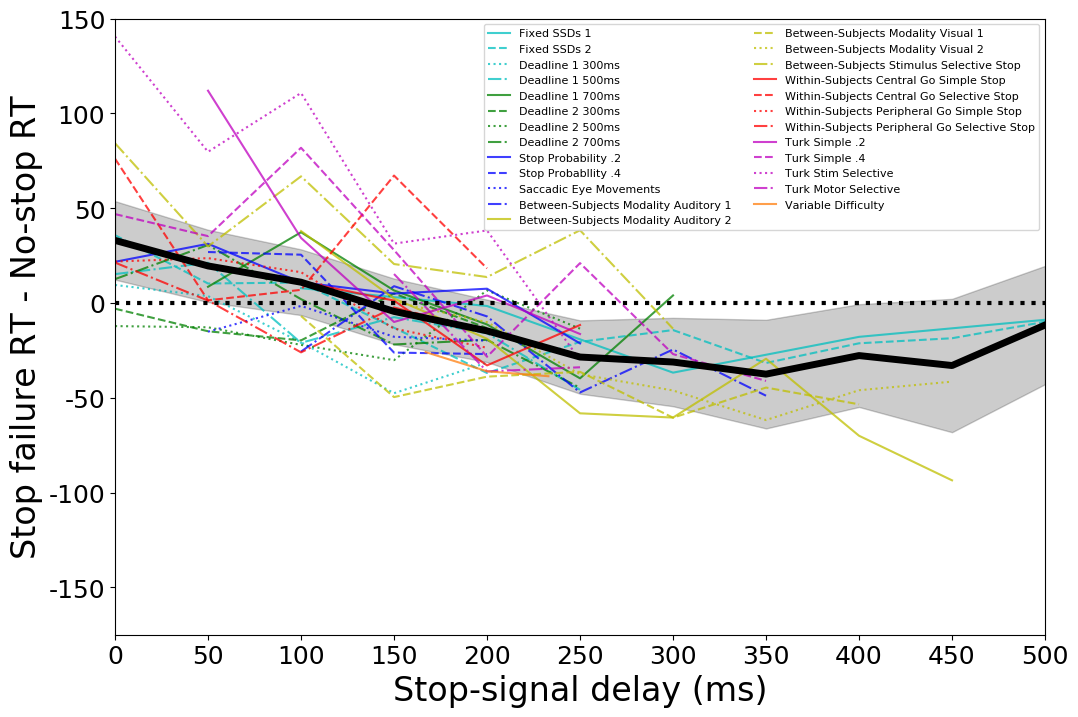

In [50]:
plt.figure(figsize=(12,8))
plt.rc('axes', prop_cycle=(cycler('color', linecolors) +
                           cycler('linestyle', linestyles)))


# plot the data
#plot all but Variable Difficulty data at SSDs that are multiples of 50
plt.plot(violations_by_SSD_widestSubset.loc[:,[col for col in violations_by_SSD_widestSubset.columns if 'Matzke' not in col]],
        alpha=.75)
# plot Variable Difficulty at SSDs which may be in thirds of 100ms (e.g 166ms, 233ms)
plt.plot(matzke_series, color=linecolors[-1], alpha=.75)

# plot mean & CIs
plt.plot(ci_s1['SSD_factor'].astype(int), ci_s1.emmean,linewidth=5, #plot mean
             linestyle='solid' ,color='k')
plt.fill_between(ci_s1['SSD_factor'].astype(int), ci_s1['lower.CL'], ci_s1['upper.CL'], color='k', alpha=0.2) #plot 95% CI
plt.axis([0,500,-150,150])

# Add the patch to the Axes
ax=plt.gca()

plt.plot([0,500],[0,0],color='k',linestyle=':',linewidth=3)
plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('Stop failure RT - No-stop RT',fontsize=24)
xticks=np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(-200,200,50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=18)
ax.set_ylim([-175, 150])
plt.legend([condition_name_dict[col] for col in violations_by_SSD_widestSubset.columns],ncol=2, fontsize=8)

plt.savefig(path.join(SUPPLEMENT_DIR, 'FigureS1.png'))
plt.show()
_ = plt.close()

# __S2__ - Figure 2a With Legend

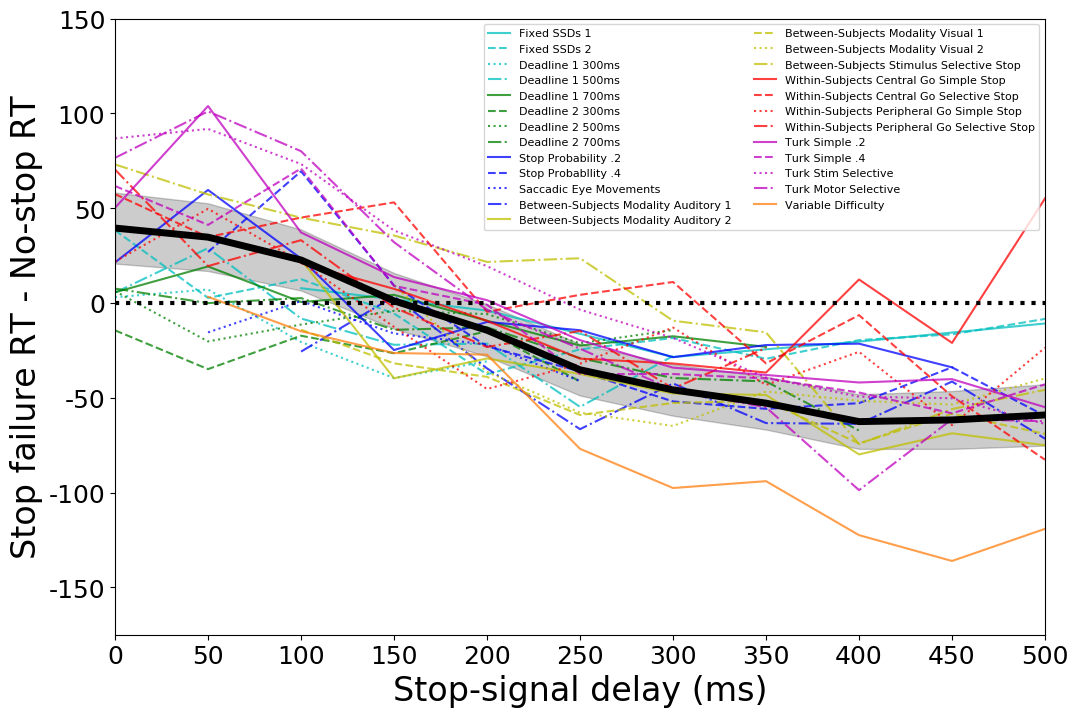

In [51]:
plt.figure(figsize=(12,8))
plt.rc('axes', prop_cycle=(cycler('color', linecolors) +
                           cycler('linestyle', linestyles)))

# plot the data
plt.plot(violation_by_SSD_perCondition, alpha=0.75)
plt.plot(ci['SSD_factor'].astype(int), ci.emmean,linewidth=5, #plot mean
             linestyle='solid' ,color='k')
plt.fill_between(ci['SSD_factor'].astype(int), ci['asymp.LCL'], ci['asymp.UCL'], color='k', alpha=0.2) #plot 95% CI
plt.axis([0,500,-150,150])


ax=plt.gca()


plt.plot([0,500],[0,0],color='k',linestyle=':',linewidth=3)
plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('Stop failure RT - No-stop RT',fontsize=24)
xticks=np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(-200,200,50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=18)
ax.set_ylim([-175, 150])
plt.legend([condition_name_dict[col] for col in violation_by_SSD_perCondition.columns],ncol=2, fontsize=8)


plt.savefig(path.join(SUPPLEMENT_DIR, 'FigureS2.png'))
plt.show()
_ = plt.close()

# __S3__ - Figure 2c With Legend

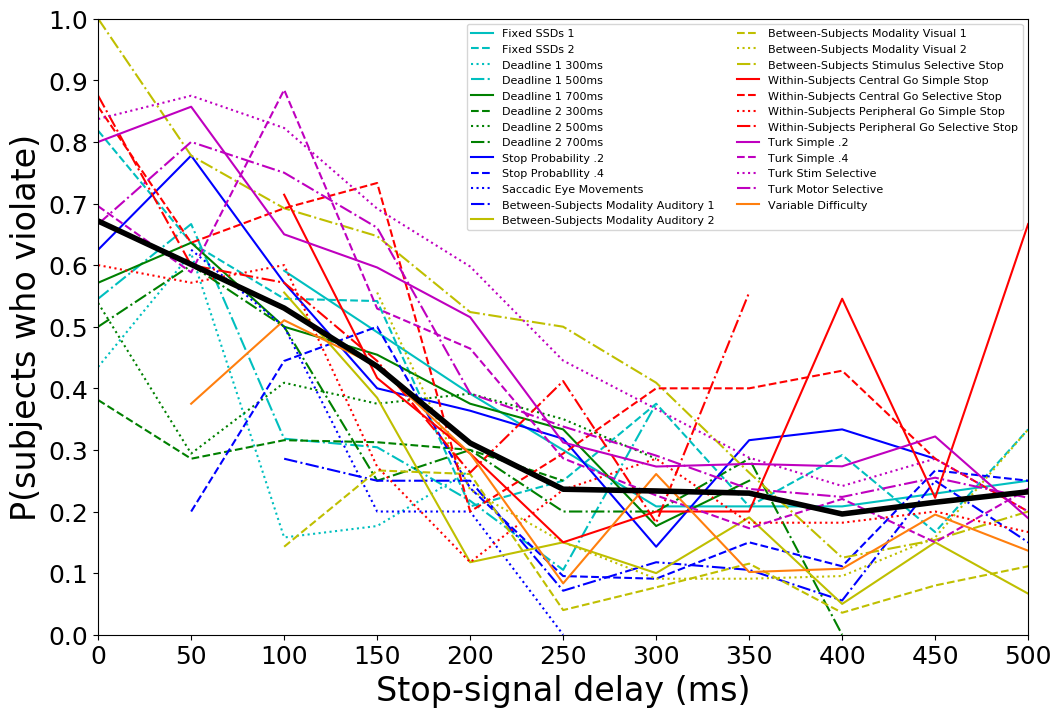

In [52]:
plt.figure(figsize=(12,8))

# plot the data
plt.plot(proportionSubjectsViolating_per_SSD)
# plot mean

plt.plot(proportionSubjectsViolating_per_SSD.mean(1),linewidth=4,color='k', linestyle='solid')
plt.axis([0,500,0,1])

ax=plt.gca()



plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('P(subjects who violate)',fontsize=24)
xticks=np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,1.1,0.1)
ax.set_yticks(yticks)
ax.set_yticklabels(['%0.1f'%i for i in yticks],fontsize=18)
plt.legend([condition_name_dict[col] for col in proportionSubjectsViolating_per_SSD.columns],ncol=2, fontsize=8)

plt.savefig(path.join(SUPPLEMENT_DIR, 'FigureS3.png'))
plt.show()
_ = plt.close()

# __S4__ - Figure 2a With Extended Axes

In [71]:
alldata = alldata_full[alldata_full.subject.isin(kept_subjects)]

In [110]:
%%R -i alldata -o lmer_sum,ci

alldata$SSD_factor = as.factor(alldata$ssd)
lmer.result <- lmer(violation ~ SSD_factor + (1|subject) + (1|study), data=alldata)
lmer_sum = summary(lmer.result)
em = emmeans(lmer.result, specs='SSD_factor') #pbkrtest.limit = 8947 - command should allow for df computation
ci = confint(em) # run only to get the estimates for each SSD, not a significance test!

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8797' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8797)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8797' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8797)' or larger];
but be warned that this may result in large computation time and memory use.



In [81]:
ci = ci[ci.SSD_factor.astype(float).isin(np.arange(0, 950, 50))] 

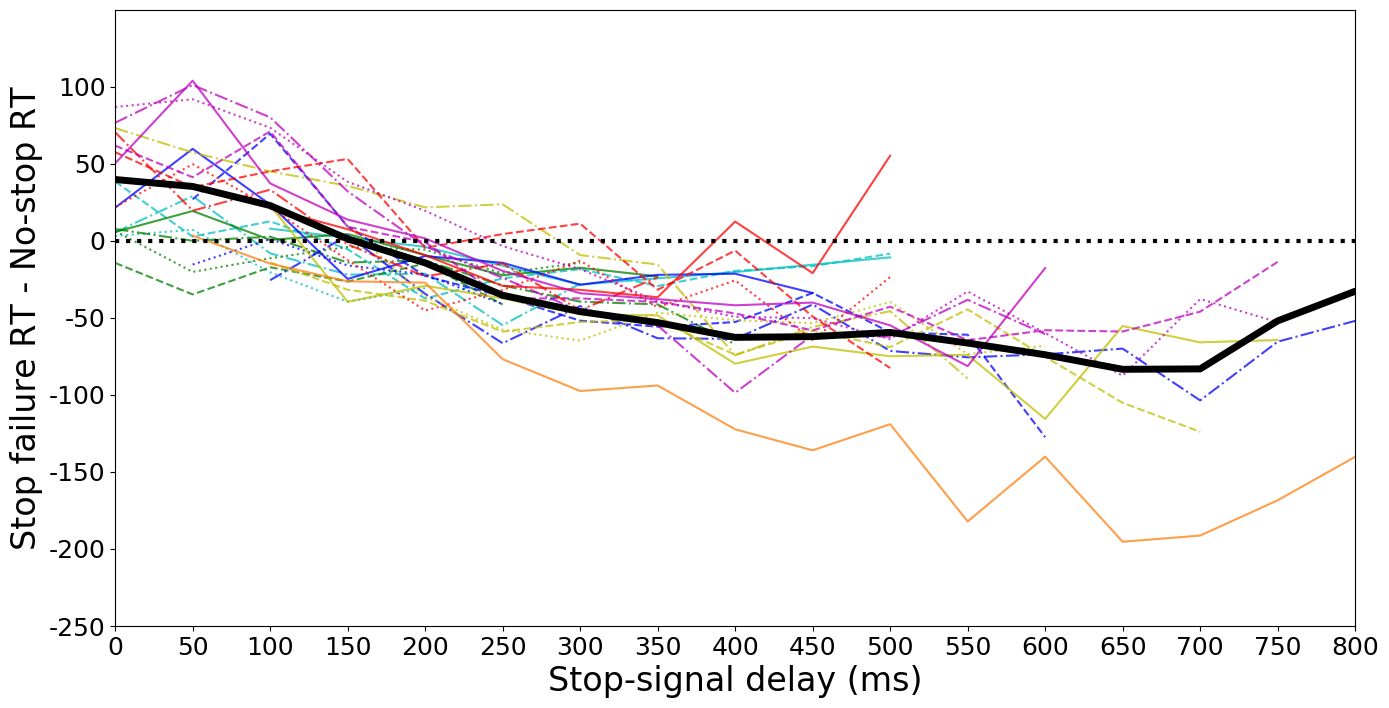

In [82]:
plt.figure(figsize=(16,8))
plt.rc('axes', prop_cycle=(cycler('color', linecolors) +
                           cycler('linestyle', linestyles)))


# plot the data
plt.plot(violation_by_SSD_perCondition_full, alpha=.75)
plt.plot(ci['SSD_factor'].astype(int), ci.emmean,linewidth=5, #plot mean
             linestyle='solid' ,color='k')
plt.axis([0,800,-150,150])
# plot mean

ax=plt.gca()

plt.plot([0,800],[0,0],color='k',linestyle=':',linewidth=3)
plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('Stop failure RT - No-stop RT',fontsize=24)
xticks=np.arange(0,850,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(-250,150,50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=18)

plt.savefig(path.join(SUPPLEMENT_DIR, 'FigureS4.png'))
plt.show()
_ = plt.close()

# __S5__

In [56]:
# load df
fixedSSD2_df= read_cond_file('Data/DataFixedSSDs2.xlsx')

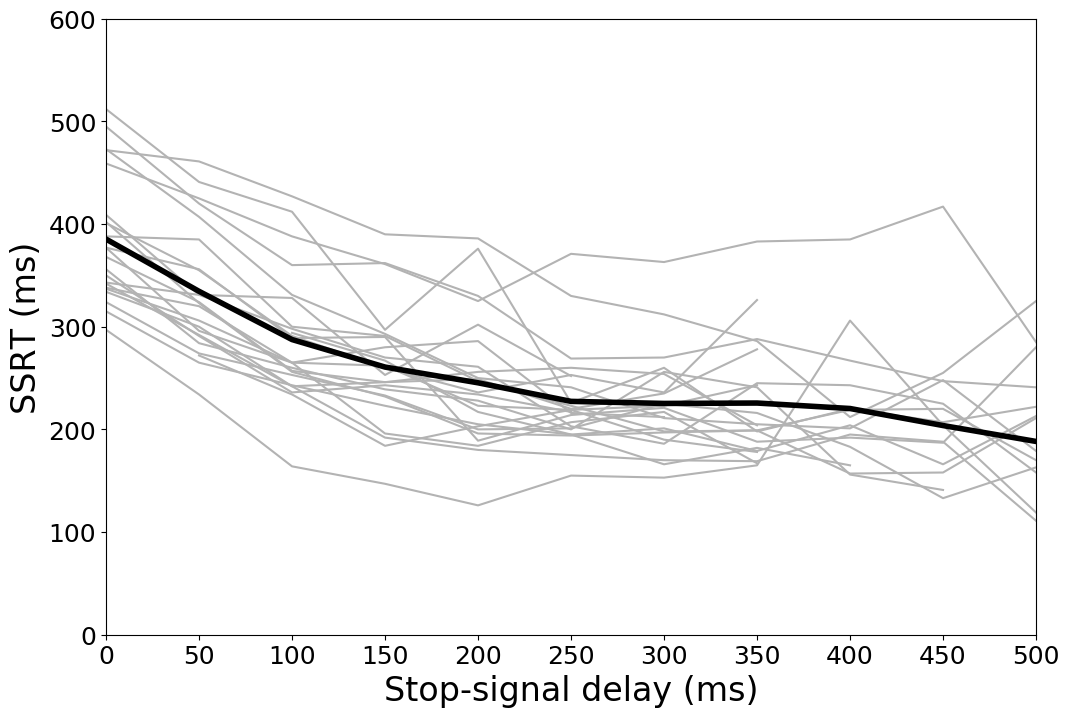

In [57]:
#build up dictionary of SSRTs per SSD per subject
ssdvals = [i for i in fixedSSD2_df.StopSignalDelay.unique() if i==i and i >=0] #ignore nan/missing values and negative SSDs
SSRTs_per_ssd_per_subj = {}

for subject in fixedSSD2_df.Subject.unique():
    #initialize subject dict, get subject data
    SSRTs_per_ssd_per_subj[subject] = {}
    subdata = fixedSSD2_df.query('Subject == %d' % subject).copy()
    
    SSRTs_per_ssd = []
    for ssdval in ssdvals:
        #Get SSRT using only stop trials at that SSD
        ssd_data = subdata[(subdata.StopSignalDelay == ssdval) | (subdata.StopSignalDelay.isnull())].copy()
        SSRT, _ = calc_SSRT(ssd_data, method='replacement')
        SSRTs_per_ssd_per_subj[subject][ssdval]=SSRT

# convert into df, organize
s5_df = pd.DataFrame(SSRTs_per_ssd_per_subj)
s5_df = s5_df.sort_index()
s5_df = s5_df.reindex(sorted(s5_df.columns), axis=1)

#PLOT
ssd_range = np.arange(0,550,50)
plt.figure(figsize=(12,8))
plt.plot(ssd_range, s5_df, linewidth=1.5,linestyle='-',color='.7')
plt.plot(ssd_range, s5_df.mean(1),linewidth=4,color='k')
ax=plt.gca()
plt.axis([0,500,0,600])
xticks=ssd_range
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,650,100)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=18)
plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('SSRT (ms)',fontsize=24)

plt.savefig(path.join(SUPPLEMENT_DIR, 'FigureS5.png'))
plt.show()
_ = plt.close()

# __S6__

In [58]:
violating_conditions = []
for cond, ci_df in ci_dict.items():
    positive_short_violations = ci_df[ci_df.query('SSD <= 500')['lower.CL'] > 0]
    
    if len(positive_short_violations) > 0:
        violating_conditions.append((cond, len(positive_short_violations)))
violating_conditions

[('FixedSSDs2', 1),
 ('StopProbabilityHigh', 1),
 ('TurkSimpleLow', 2),
 ('TurkSimpleHigh', 2),
 ('TurkStimSelec', 5),
 ('TurkMotorSelec', 3)]

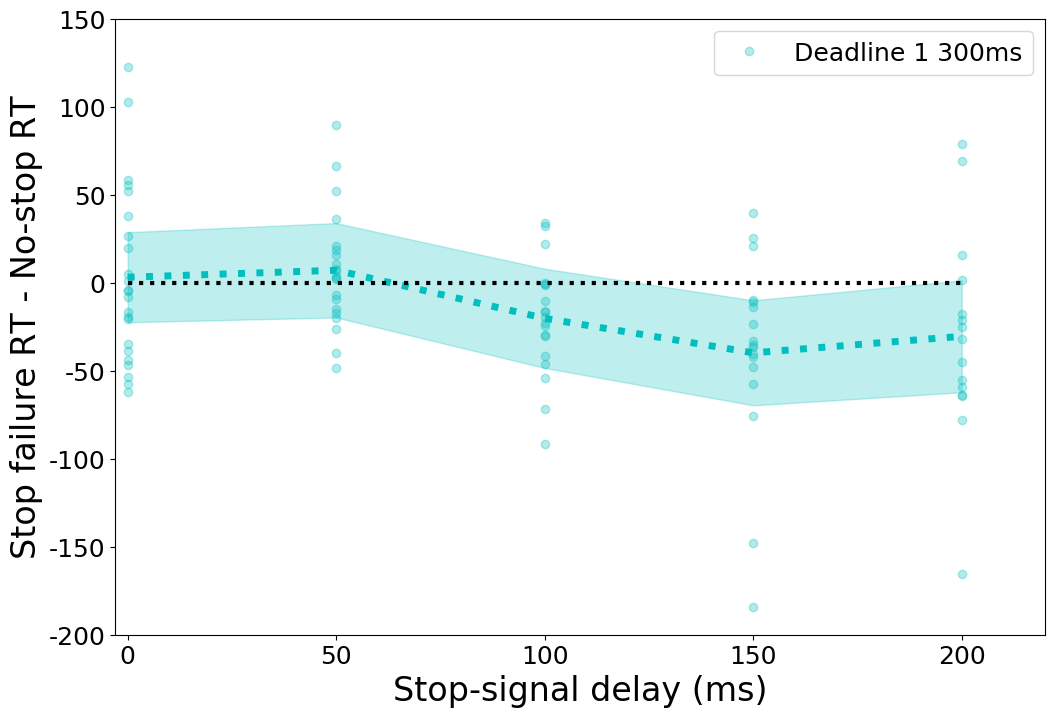

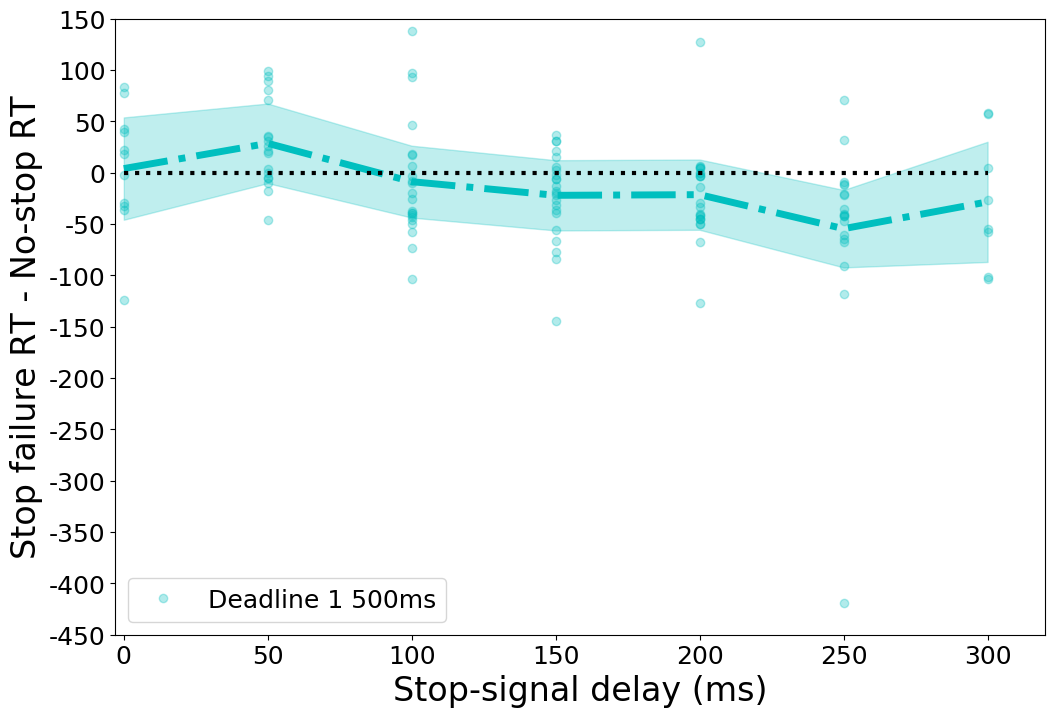

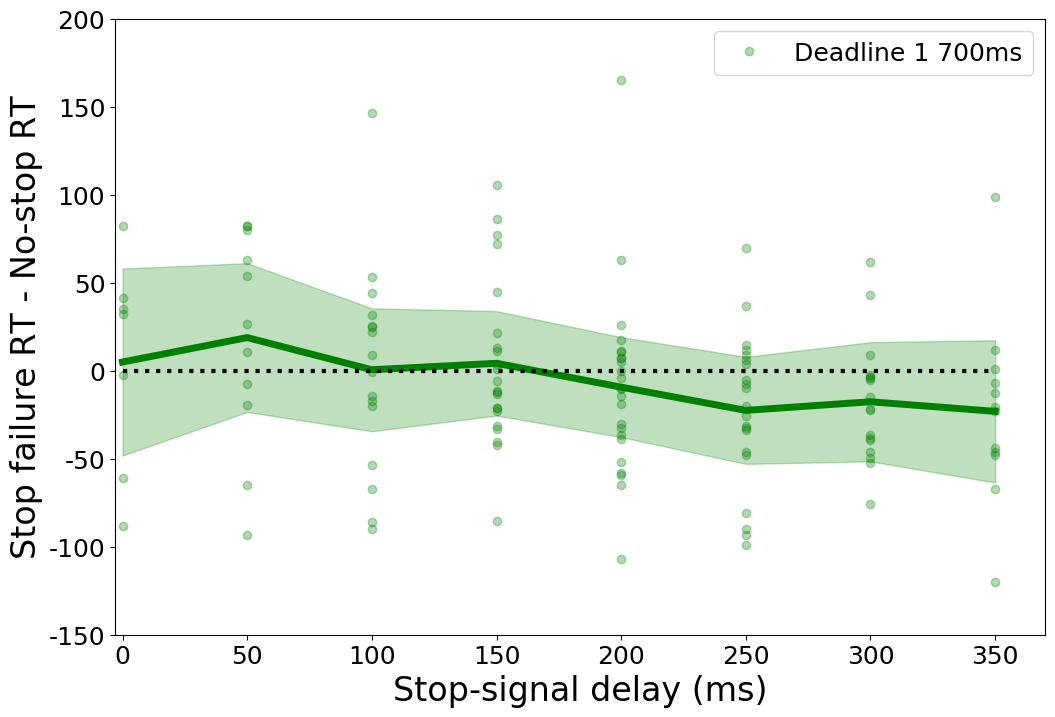

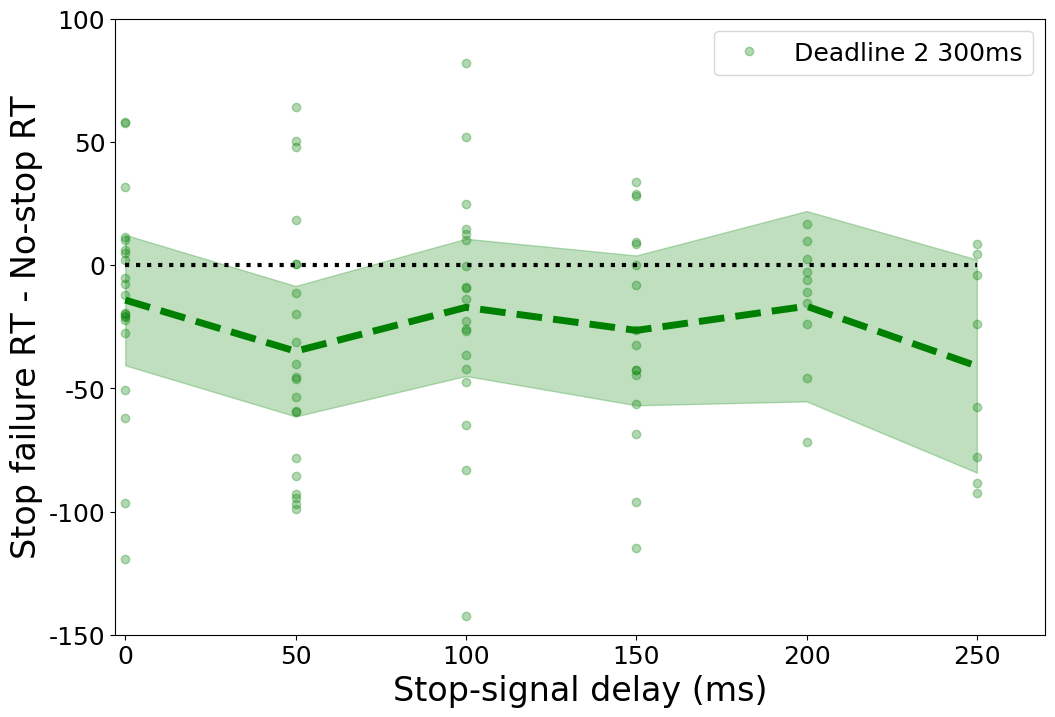

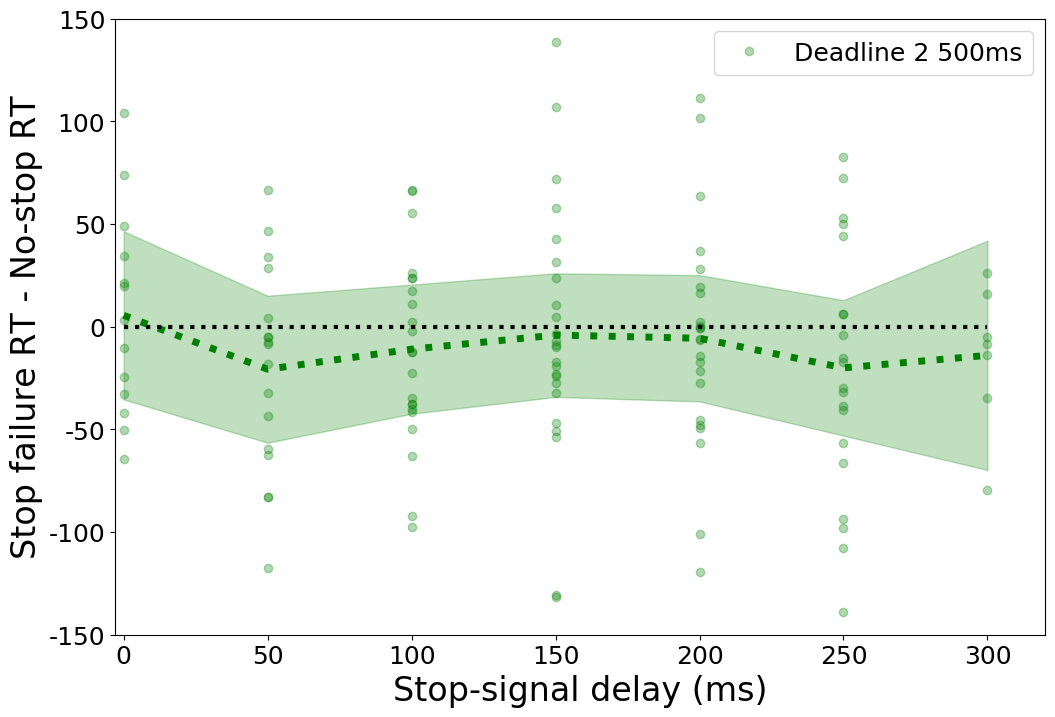

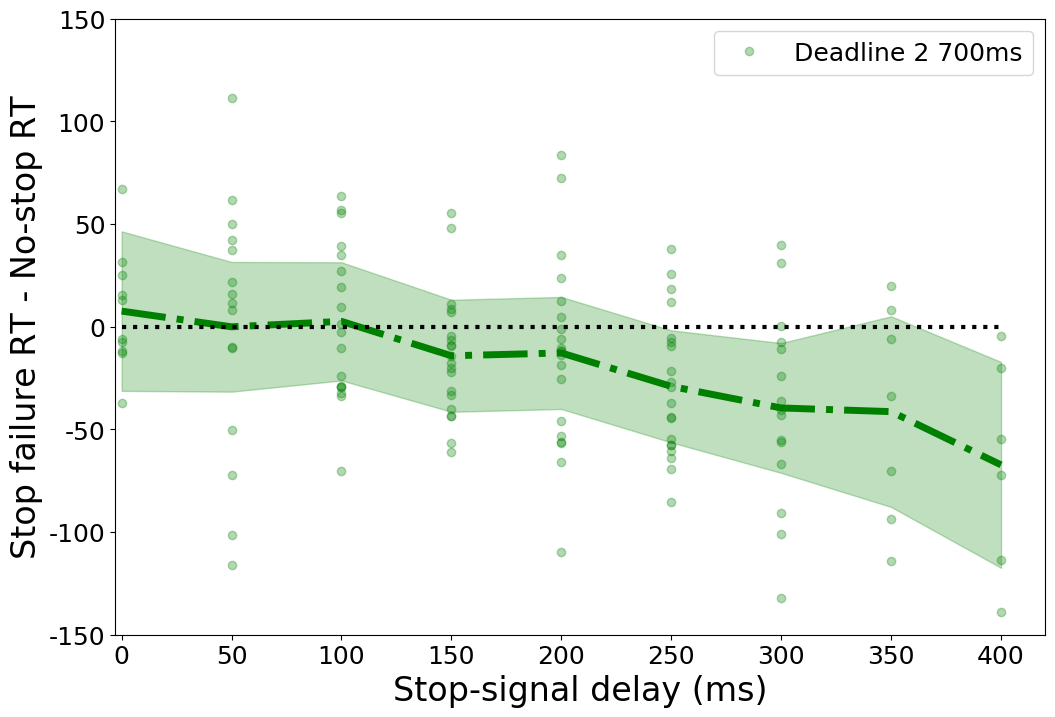

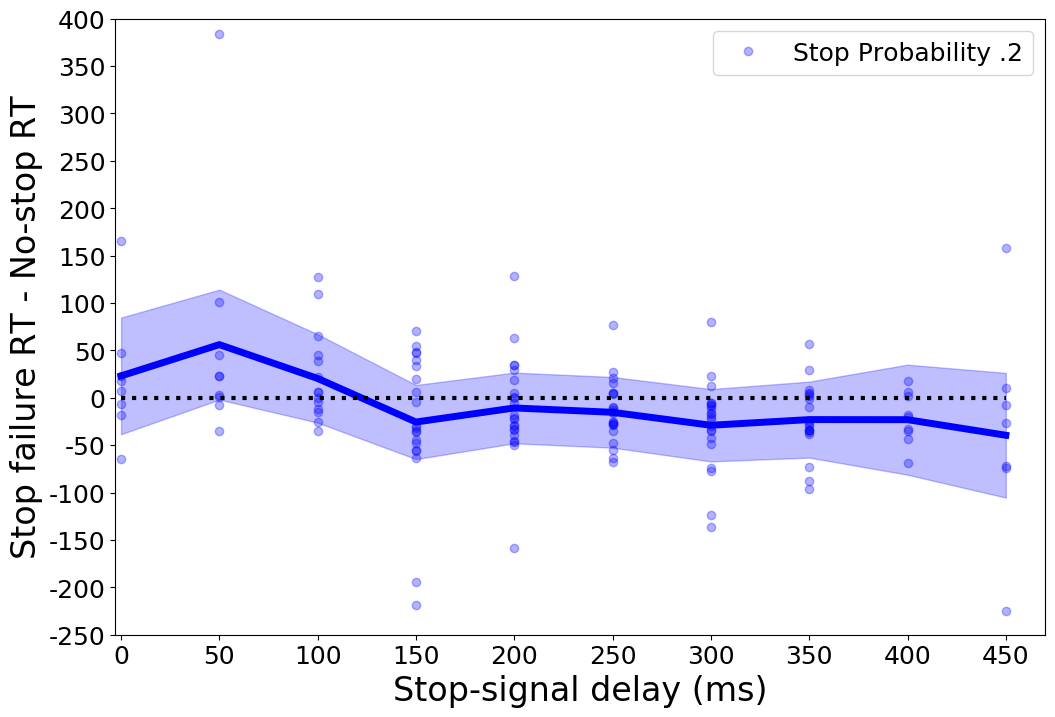

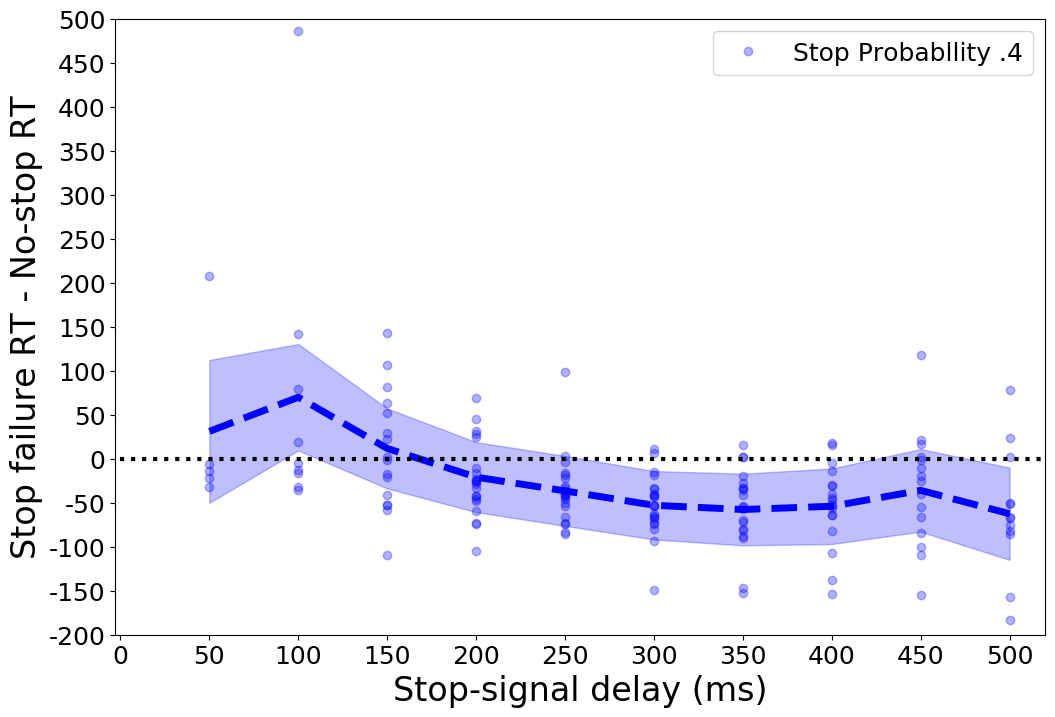

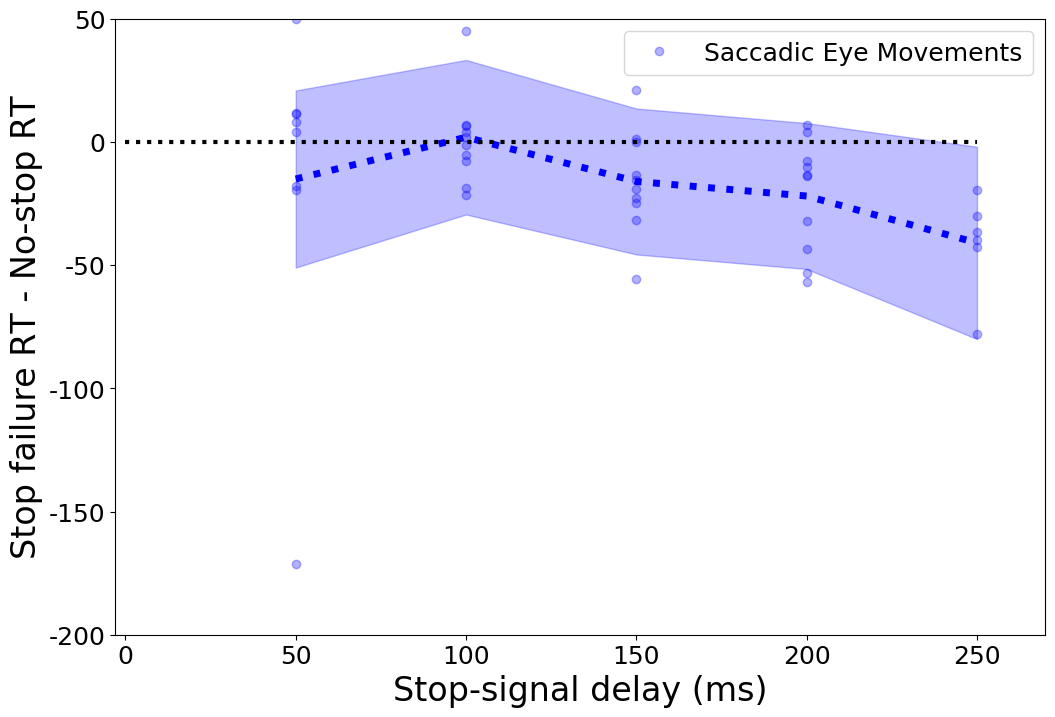

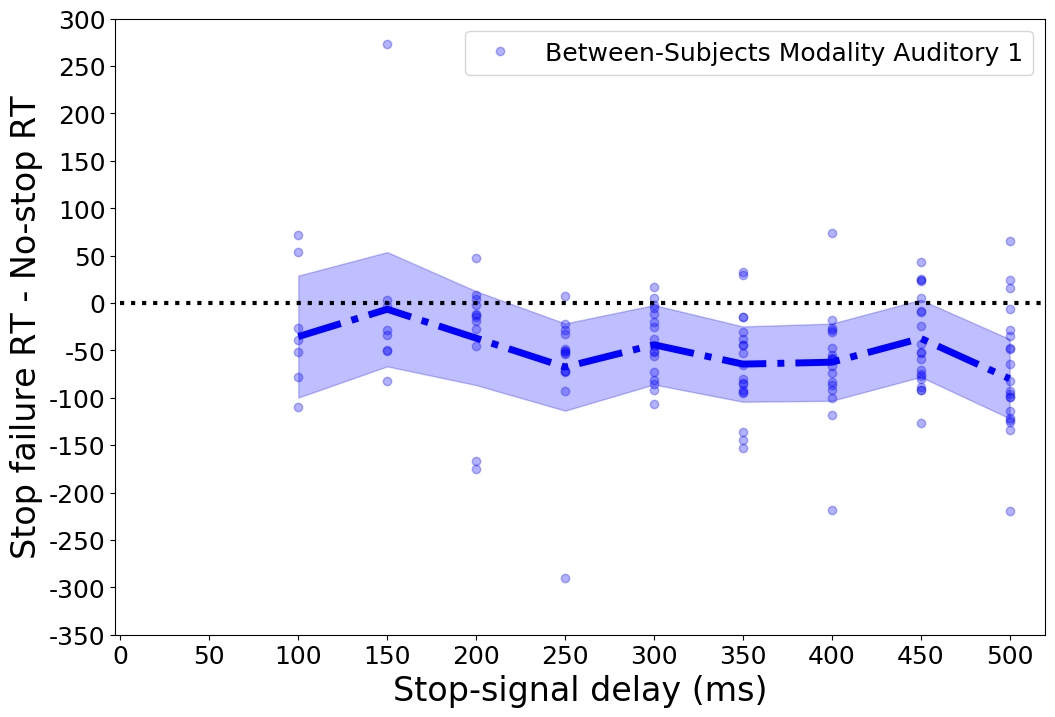

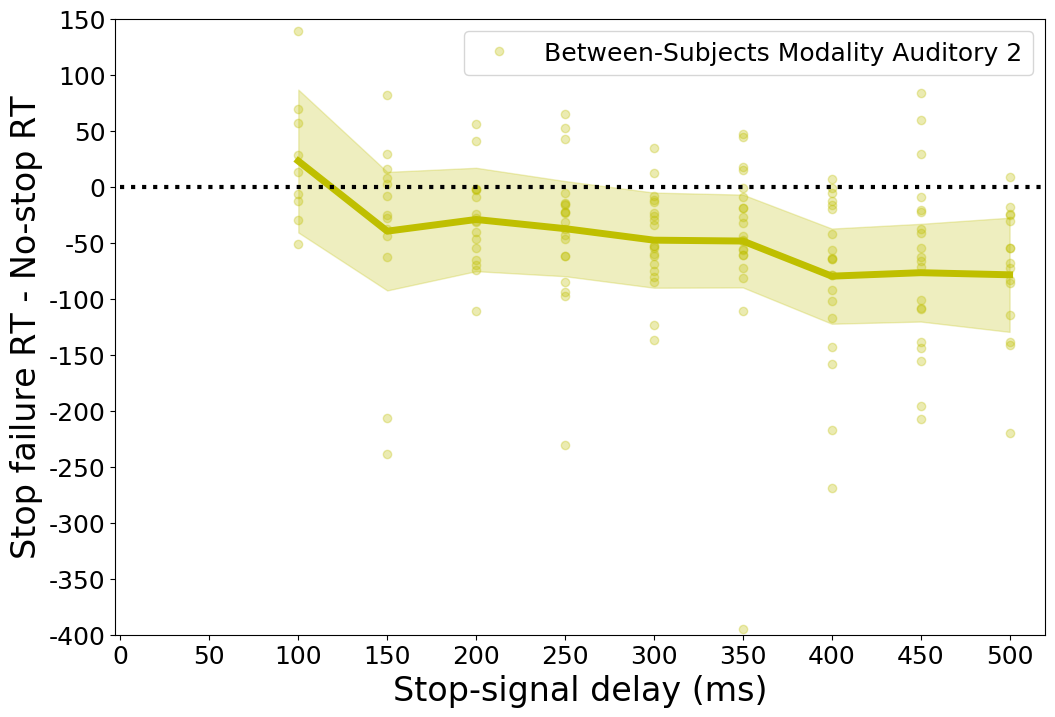

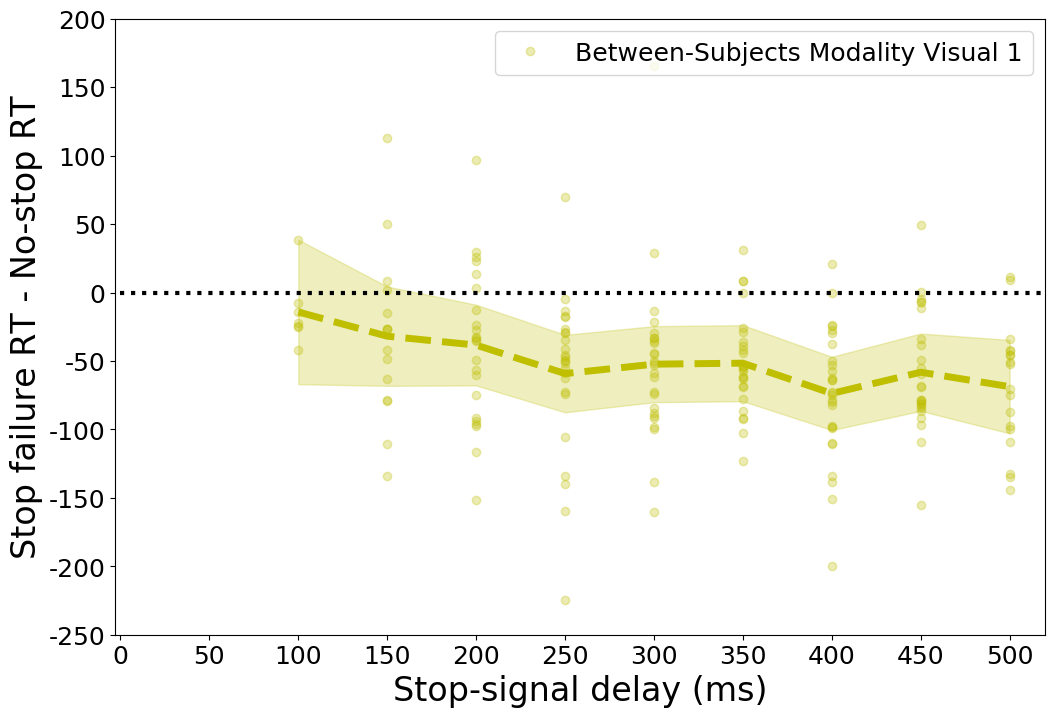

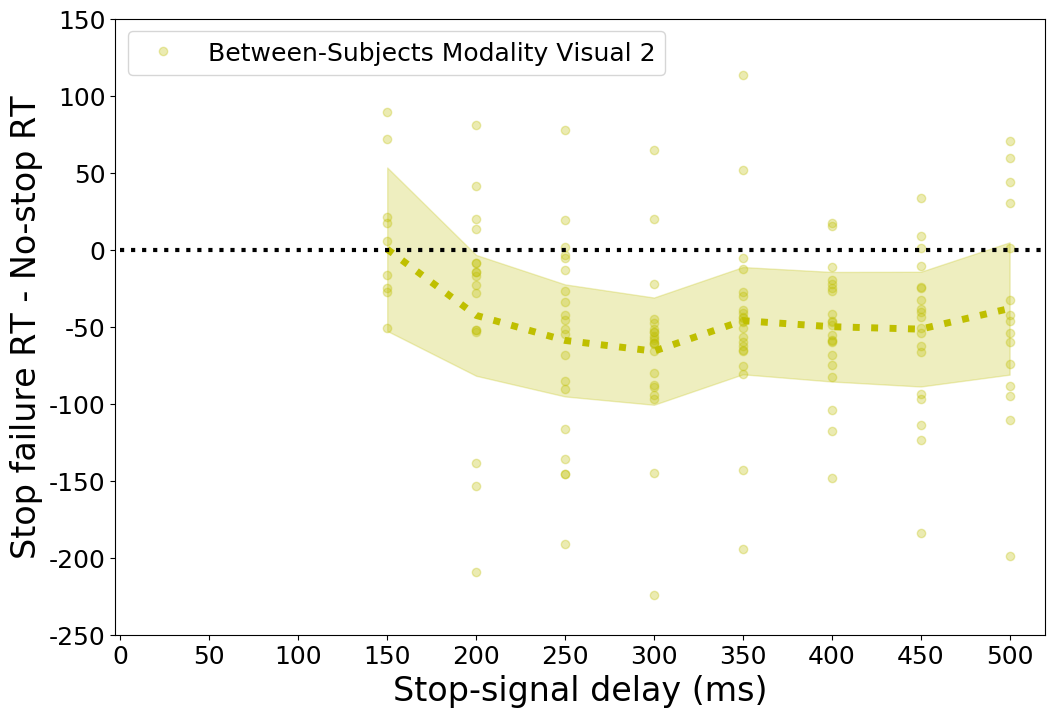

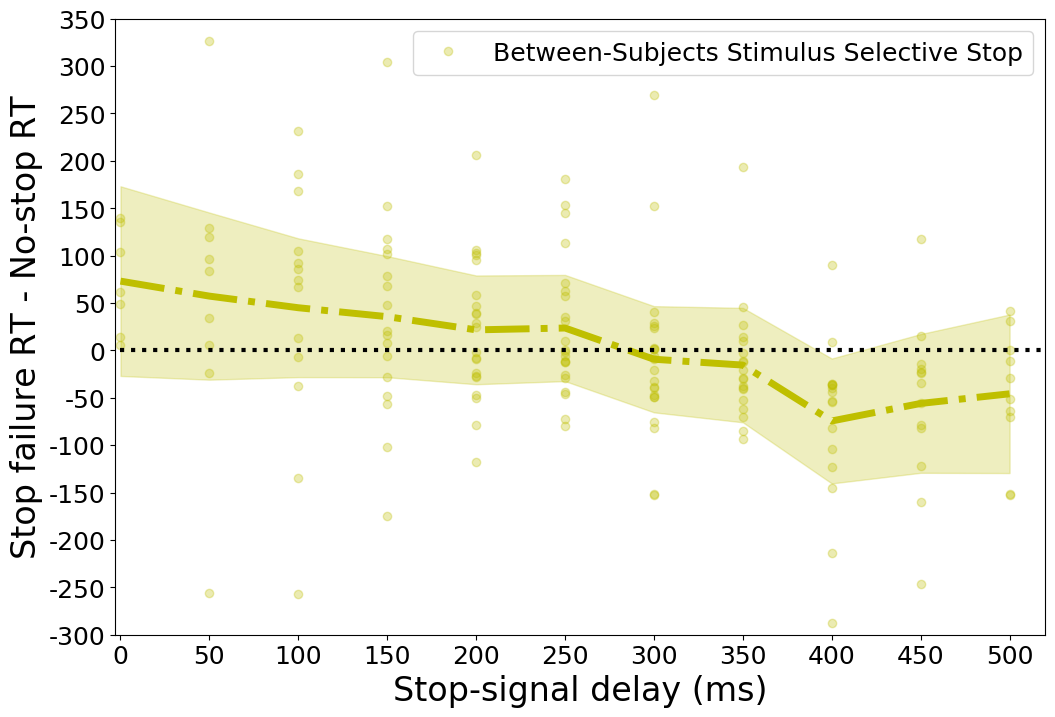

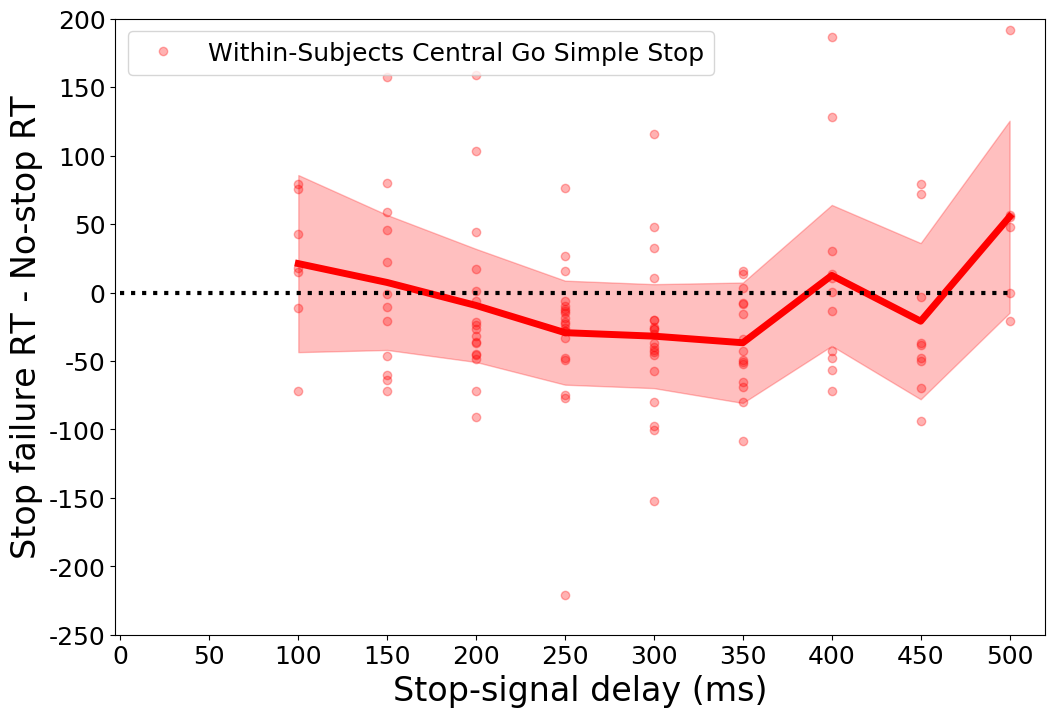

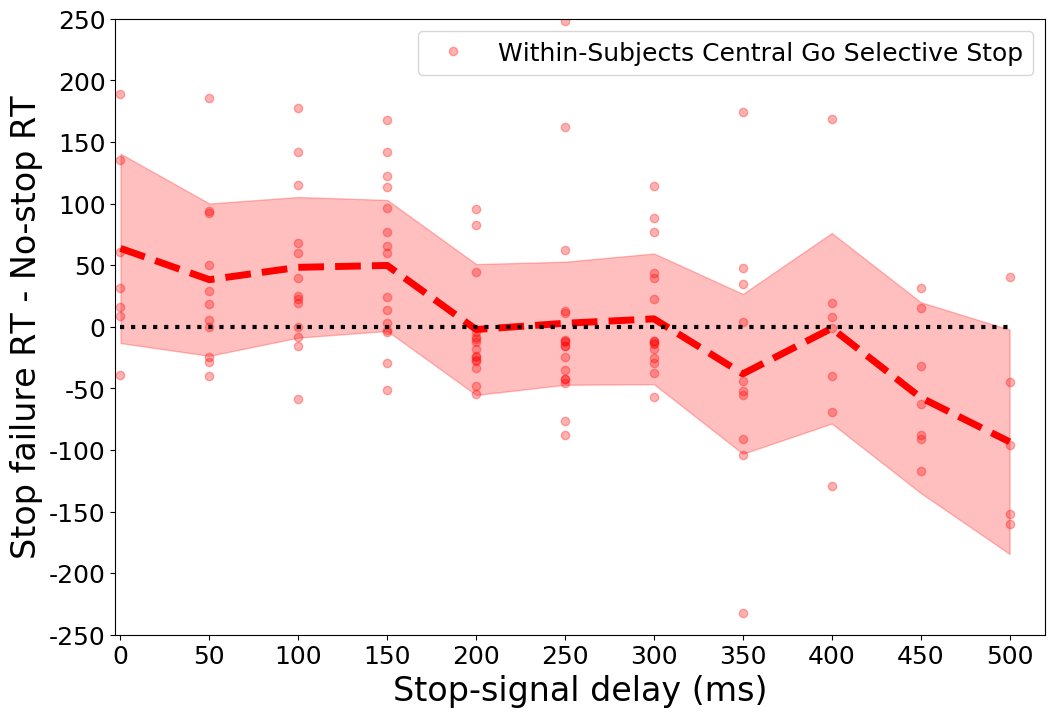

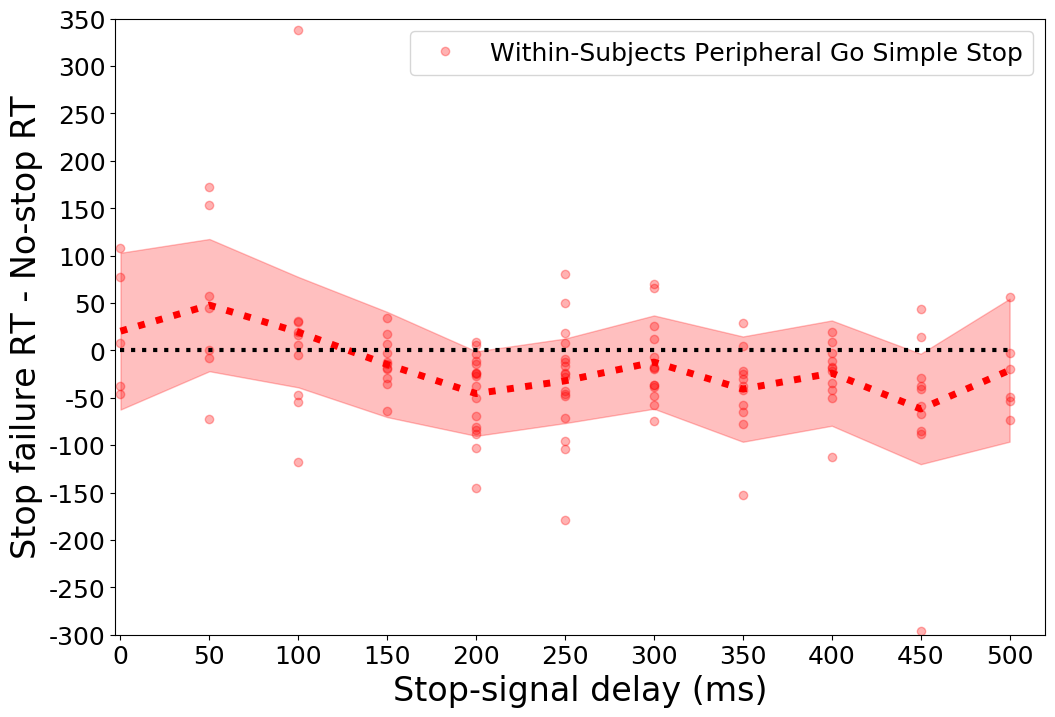

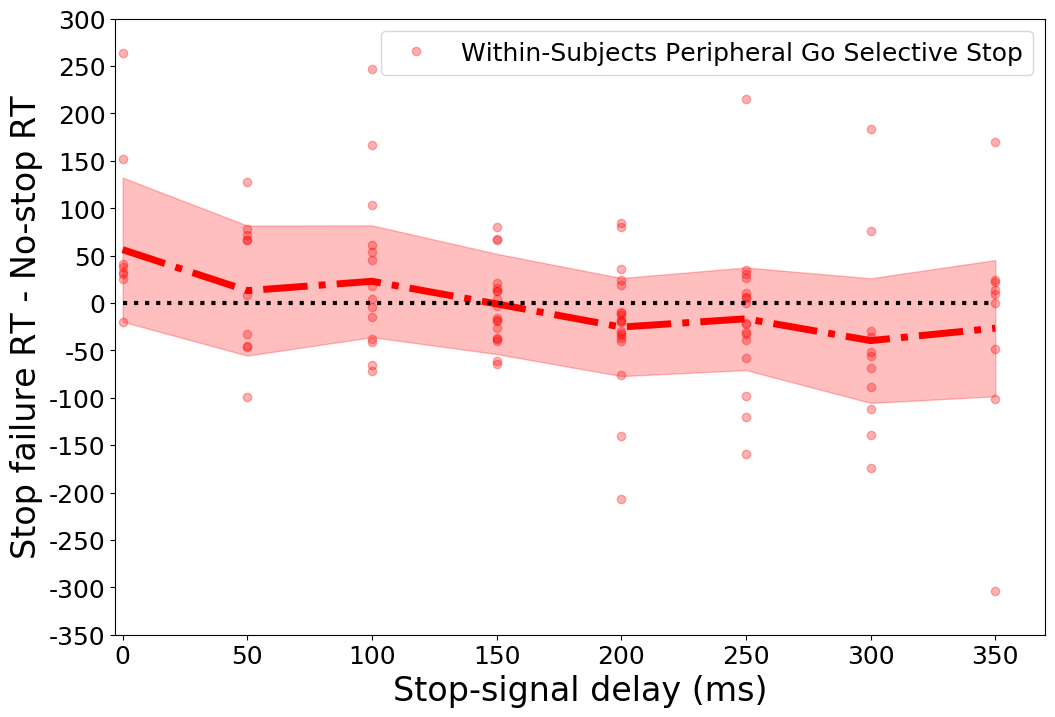

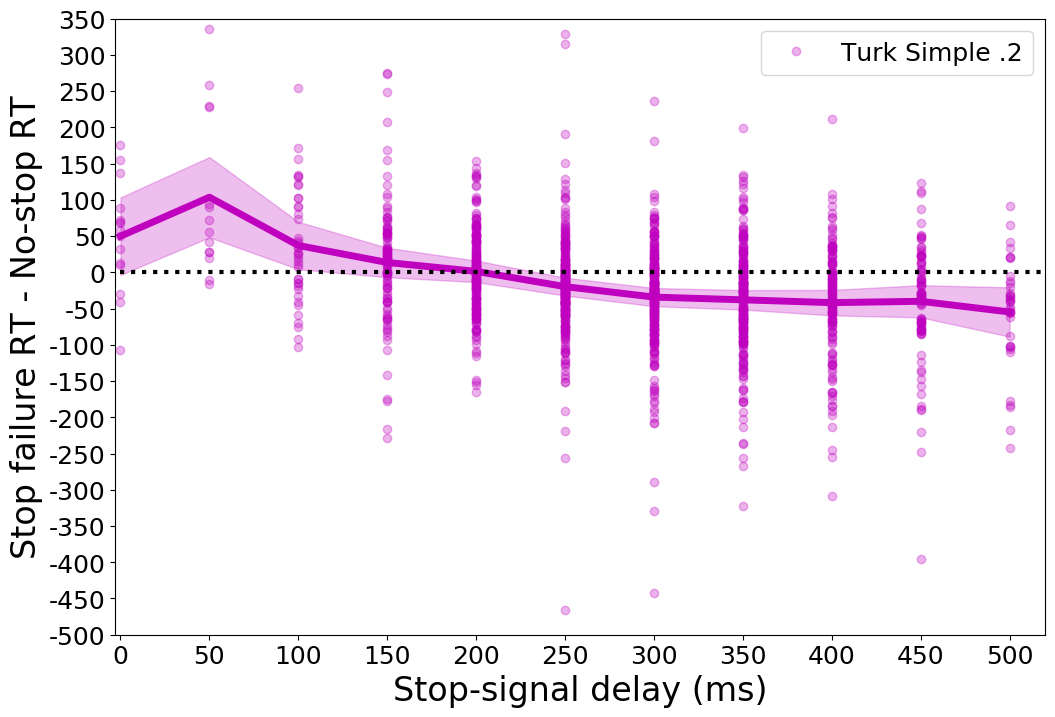

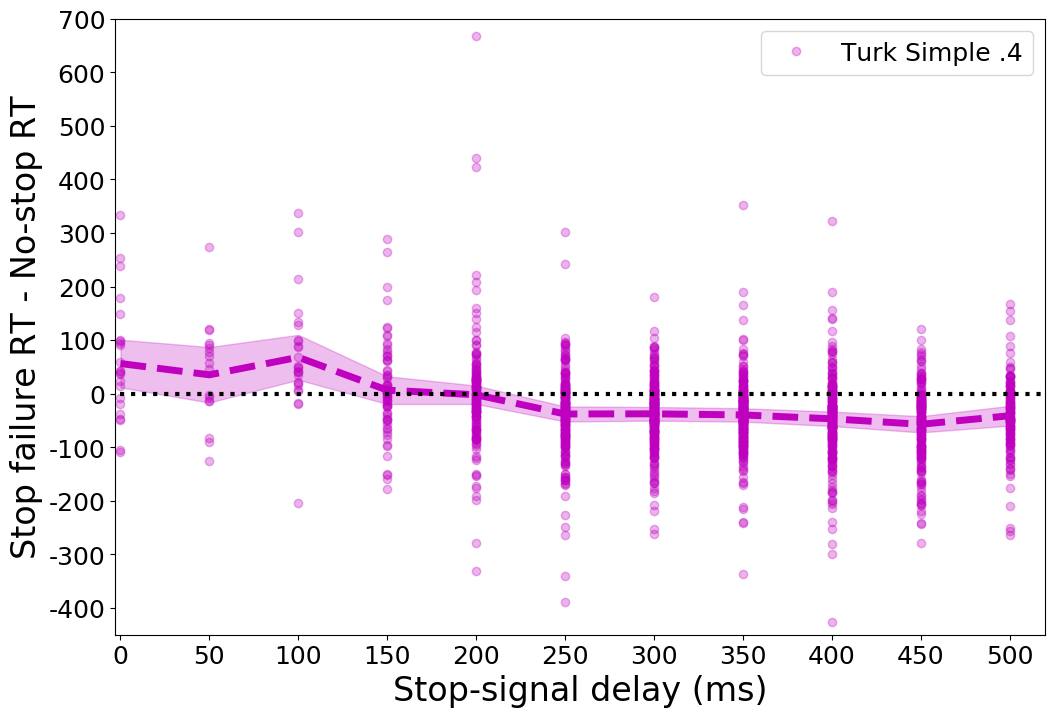

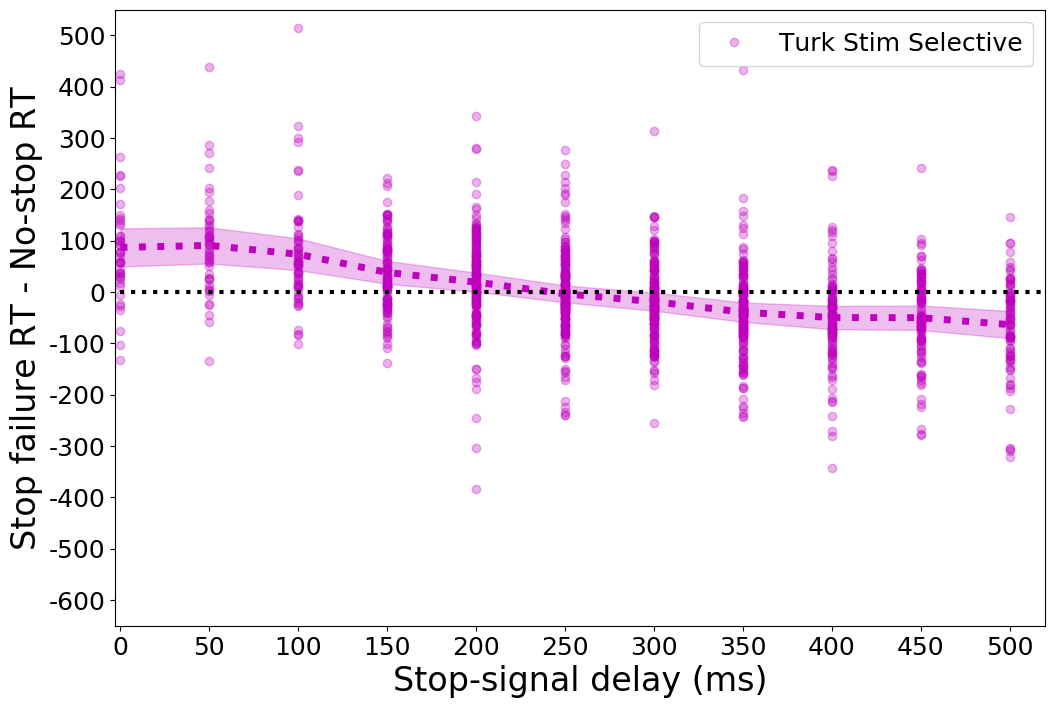

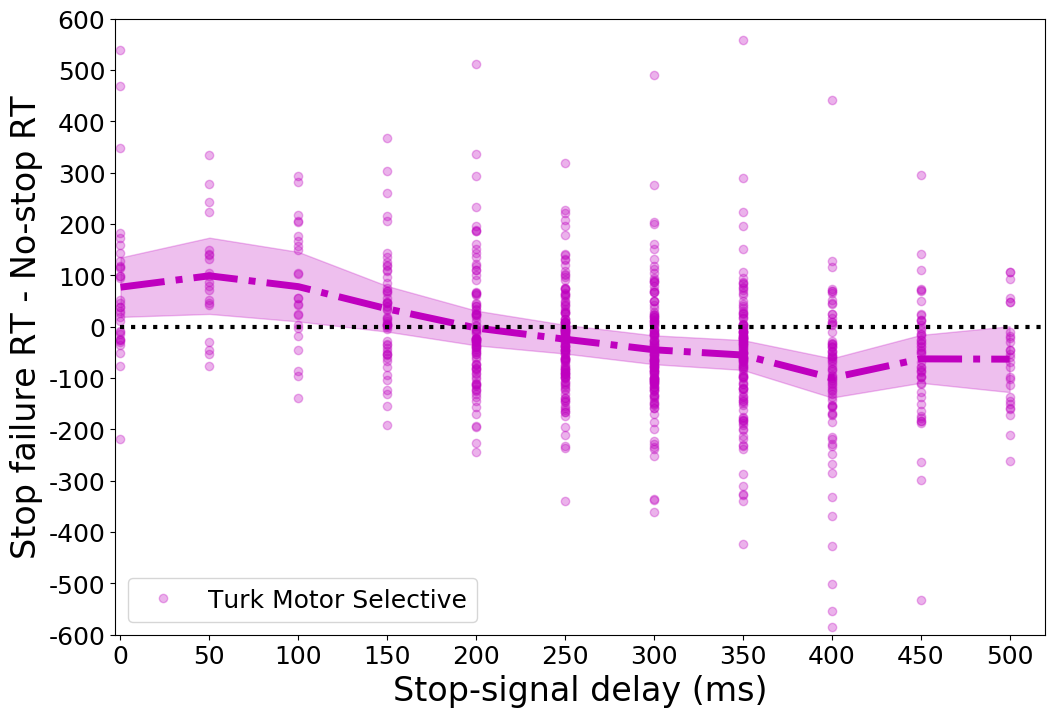

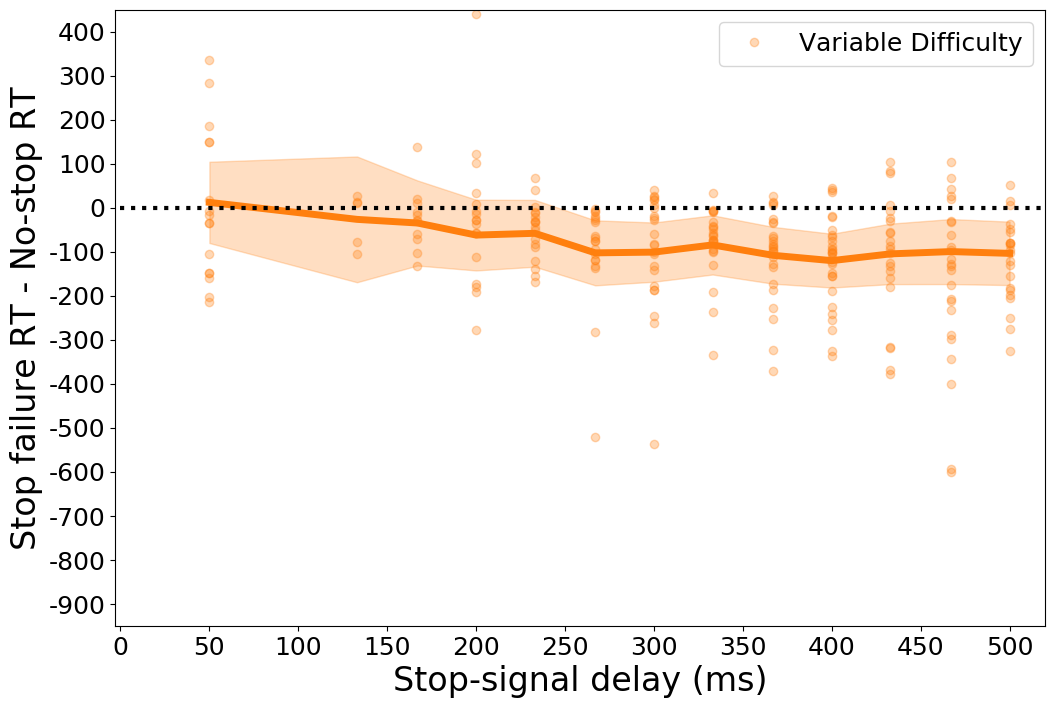

In [85]:
#generate remaining lme condition figures
for idx, condition_name in enumerate(short_names[2:]):
    idx+=2 #shift to account for Fig1

    # get mean and confidence intervals from lmer
    ci = ci_dict[condition_name]
    
    #get individuals and bounds from violational analyses
    curr_df = pd.read_csv(f'SummaryData/summarydata{condition_name}.csv')
    pivot_df = curr_df.pivot_table(values='mean_violation', index=['ssd'],
                        columns=['subject'])
    
    #PLOT AND SAVE
    Y_LOWER = round_to_50(pivot_df.min().min())
    Y_UPPER = round_to_50(pivot_df.max().max())

    plt.figure(figsize=(12,8))
    plt.plot(pivot_df, linewidth=0, color=linecolors[idx], marker='o', alpha=.3) #plot individuals
    plt.plot(ci['SSD_factor'].astype(int), ci.emmean,linewidth=5,  #plot mean
                 linestyle=linestyles[idx], color=linecolors[idx])
    plt.fill_between(ci['SSD_factor'].astype(int), ci['lower.CL'], ci['upper.CL'], color=linecolors[idx], alpha=0.25) #plot 95% CI
    
    
    #set limits
    ax=plt.gca()
    plt.axis([-3,ci['SSD_factor'].astype(int).max()+20,Y_LOWER,Y_UPPER])
    xticks=np.arange(0,np.min([pivot_df.index.max()+50, 550]),50)
    xticks = [int(i) for i in xticks]
    if len(xticks)> 16:
        xticks = [i for i in xticks if i%100==0]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,fontsize=18) 
    yticks=np.arange(Y_LOWER,Y_UPPER+50,50)
    yticks = [int(i) for i in yticks]
    if len(yticks)>= 20:
        yticks = [i for i in yticks if i%100==0]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks,fontsize=18)
    plt.plot([0,pivot_df.index.max()],[0,0],color='k',linestyle=':',linewidth=3)
    plt.xlabel('Stop-signal delay (ms)',fontsize=24)
    plt.ylabel('Stop failure RT - No-stop RT',fontsize=24)
    plt.legend([condition_name_dict[condition_name]], fontsize=18)
    #Save
    plt.savefig(path.join(S6_DIR, f'FigureS6_{condition_name}.png')) #change name to match first line
    plt.show()
    plt.close()

# __S7__ - Figure 1d With Full Legend

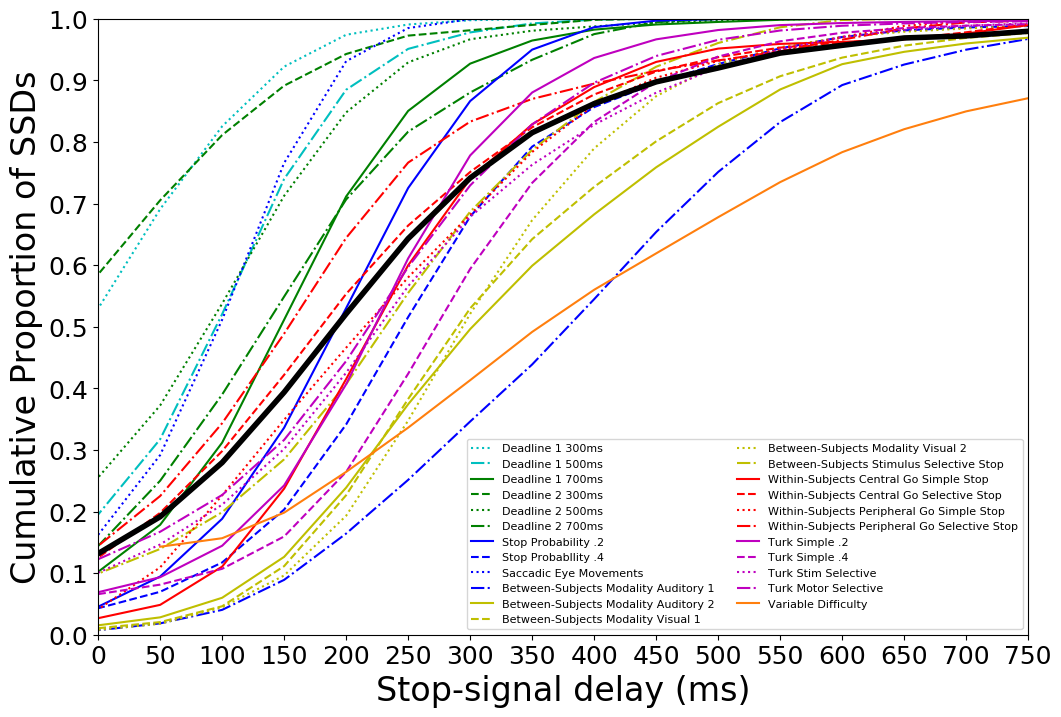

In [60]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
# iterate over conditions, keeping color and marker order
for idx, col in enumerate(cumulativeStopTrials_per_ssd.columns):
    idx+=2
    if 'Fixed' not in col:
        ax.plot(cumulativeStopTrials_per_ssd[col],
                linestyle=linestyles[idx], color=linecolors[idx])


# plot the data
plt.axis([0,750,0,1])
# plot mean
ax.plot(cumulativeStopTrials_per_ssd.mean(1),linewidth=4,color='k', linestyle='solid')
ax=plt.gca()


plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('Cumulative Proportion of SSDs',fontsize=24)
xticks=np.arange(0,800,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(0,1.01,.1)
ax.set_yticks(yticks)
ax.set_yticklabels(['%0.1f'%i for i in yticks],fontsize=18)
plt.legend([condition_name_dict[col] for col in cumulativeStopTrials_per_ssd.columns],ncol=2, fontsize=8)

plt.savefig(path.join(SUPPLEMENT_DIR, 'FigureS7.png'))
plt.show()
_ = plt.close()

# __S8__ - Figure 3a With Full Legend

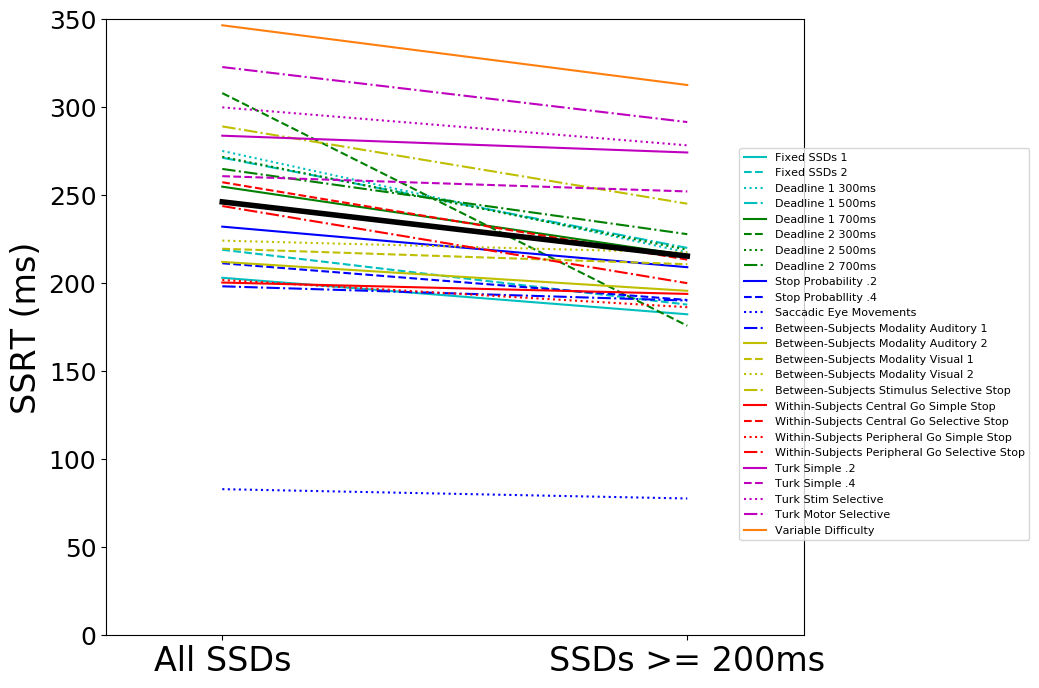

In [61]:
#PLOT
plt.figure(figsize=(9,8))
plt.rc('axes', prop_cycle=(cycler('color', linecolors) +
                           cycler('linestyle', linestyles)))

# plot the data
plt.plot(data2c_df)

plt.axis([-0.25,1.25, 0, 350]) # previously [.75,2.25, 0,350]

# plot mean
plt.plot(data2c_df.mean(1),linewidth=4,color='k', linestyle='solid')

# Add the patch to the Axes
ax=plt.gca()

# plt.xlabel('All SSDs                           SSDs >= 200ms',fontsize=24)
plt.ylabel('SSRT (ms)',fontsize=24)
ax.set_xticks([0, 1])
ax.set_xticklabels(['All SSDs', 'SSDs >= 200ms'], fontsize=24)

yticks=np.arange(0,400,50) #previously np.arange(0,400,50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=18)
plt.legend([condition_name_dict[col] for col in data2c_df.columns],ncol=1, fontsize=8, bbox_to_anchor=(.9,.8))

plt.savefig(path.join(SUPPLEMENT_DIR, 'FigureS8.png'), bbox_inches='tight')
plt.show()
_ = plt.close()

# __S9__

In [119]:
#This organizes the data for Figures 1a, 1b, 2b, and S6
table1_conditions_noSelec = [
    ['FixedSSDs1'],
    ['FixedSSDs2'],
    ['Deadline1300ms', 'Deadline1500ms', 'Deadline1700ms'],
    ['Deadline2300ms', 'Deadline2500ms', 'Deadline2700ms'],
    ['StopProbabilityLow', 'StopProbabilityHigh'],
    ['TurkSimpleLow', 'TurkSimpleHigh', 'TurkMotorSelec'],
    ['Saccades'],
    ['BtwnSubjAuditory1'],
    ['BtwnSubjAuditory2'],
    ['BtwnSubjVisual1'],
    ['BtwnSubjVisual2'],
    ['WithinSubjCentralGoSimple',
     'WithinSubjPeriphGoSimple'],
    ['Matzke']
]

data = {}
alldata_noSelec = None
for i, curr_conds in enumerate(table1_conditions_noSelec):
    for cond_name in curr_conds:
        file = 'SummaryData/summarydata'+cond_name+'.csv'
        va_df = pd.read_csv(file)
        piv_df = va_df.pivot(index='ssd', columns='subject', values='mean_violation') # pivot to introduce nans
        data_long = pd.melt(piv_df.reset_index(), id_vars='ssd', value_vars = piv_df.columns, #pivot back into long format
                            var_name ='subject', value_name='violation')
        # ensure different subject numbers for each study by adding 1000*study number
        data_long['subject'] = data_long['subject'] + i*1000        
        data_long['study'] = cond_name
        if alldata_noSelec is None:
            alldata_noSelec = data_long
        else:
            alldata_noSelec = pd.concat((alldata_noSelec, data_long))
            
alldata_noSelec = alldata_noSelec.query("ssd <=500")

In [120]:
%%R -i alldata_noSelec 

sprintf('%d subjects originally', length(unique(alldata_noSelec$subject)))

[1] "650 subjects originally"


In [121]:
%%R -i alldata_noSelec -o alldata_noSelec

# drop all subjects with only a single non-NA observation
alldata_noSelec = alldata_noSelec %>% group_by(subject) %>% filter(sum(!is.na(violation))>2)

sprintf('%d subjects remaining', length(unique(alldata_noSelec$subject)))

[1] "627 subjects remaining"


In [122]:
%%R -i alldata_noSelec -o lmer_sum

alldata_noSelec$SSD_factor = as.factor(alldata_noSelec$ssd)
lmer.result <- lmer(violation ~ SSD_factor + (1|subject) + (1|study), data=alldata_noSelec)
lmer_sum = summary(lmer.result)
lmer_sum

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: violation ~ SSD_factor + (1 | subject) + (1 | study)
   Data: alldata_noSelec

REML criterion at convergence: 74181.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5325 -0.4493  0.0081  0.4659  8.5166 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept)  318.2   17.84   
 study    (Intercept)  273.0   16.52   
 Residual             5793.0   76.11   
Number of obs: 6433, groups:  subject, 627; study, 21

Fixed effects:
              Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)     28.674      6.861  164.111   4.179 4.74e-05 ***
SSD_factor50    -3.167      7.629 6012.811  -0.415   0.6781    
SSD_factor100  -15.310      7.073 6108.116  -2.165   0.0305 *  
SSD_factor133  -17.250     35.863 6332.336  -0.481   0.6305    
SSD_factor150  -35.304      6.666 6187.519  -5.297 1.22e-07 ***
SSD_factor167  -21.010     25.011 5934.095  -0.840   0

R[write to console]: 
Correlation matrix not shown by default, as p = 19 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [123]:
%%R -o ci_s9
em = emmeans(lmer.result, specs='SSD_factor') #pbkrtest.limit = 8947 - command should allow for df computation
ci_s9 = confint(em, adjust='mvt')
ci_s9$SSD = as.numeric(levels(ci_s9$SSD_factor))[ci_s9$SSD_factor]
ci_s9

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6433' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6433)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6433' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6433)' or larger];
but be warned that this may result in large computation time and memory use.



   SSD_factor     emmean        SE  df   asymp.LCL  asymp.UCL SSD
1           0  28.674411  6.860785 Inf    8.438235  48.910586   0
2          50  25.507518  6.533119 Inf    6.237807  44.777229  50
3         100  13.364424  5.738582 Inf   -3.561768  30.290616 100
4         133  11.424364 35.536342 Inf  -93.391590 116.240318 133
5         150  -6.630004  5.185567 Inf  -21.925055   8.665048 150
6         167   7.664280 24.539956 Inf  -64.717365  80.045925 167
7         200 -19.239680  4.744042 Inf  -33.232435  -5.246925 200
8         233 -17.038001 19.706594 Inf  -75.163439  41.087437 233
9         250 -41.000843  4.682288 Inf  -54.811450 -27.190236 250
10        267 -62.776758 19.240623 Inf -119.527795  -6.025721 267
11        300 -49.178514  4.664062 Inf  -62.935365 -35.421664 300
12        333 -43.156473 17.759267 Inf  -95.538186   9.225240 333
13        350 -53.290463  4.794901 Inf  -67.433228 -39.147698 350
14        367 -69.161477 17.169280 Inf -119.802997 -18.519956 367
15        

In [124]:
# drop SSDs unique to Variable Difficulty condition
non25_ssds = [i for i in ci_s9.SSD_factor.astype(str) if ('33' not in i) and ('67' not in i) and (int(i) <= 800)]
ci_s9 = ci_s9.loc[ci_s9.SSD_factor.astype(str).isin(non25_ssds), :]

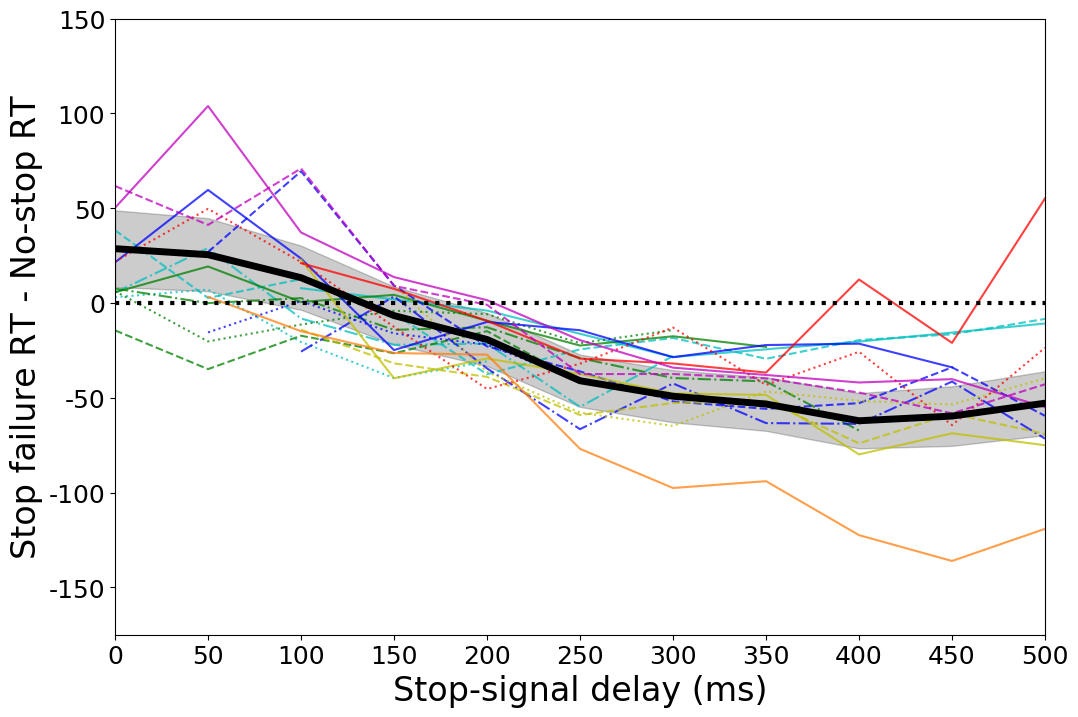

In [125]:
plt.figure(figsize=(12,8))

#plot individual condition traces
for idx, col in enumerate(violation_by_SSD_perCondition.columns):
    idx
    if 'Selec' not in col:
        plt.plot(violation_by_SSD_perCondition[col],
                linestyle=linestyles[idx], color=linecolors[idx], alpha=.75)
plt.plot(ci_s9['SSD_factor'].astype(int), ci_s9.emmean,linewidth=5, #plot mean
             linestyle='solid' ,color='k')
plt.fill_between(ci_s9['SSD_factor'].astype(int), ci_s9['asymp.LCL'], ci_s9['asymp.UCL'], color='k', alpha=0.2) #plot 95% CI
plt.axis([0,500,-150,150])


#set limits
ax=plt.gca()


plt.plot([0,500],[0,0],color='k',linestyle=':',linewidth=3)
plt.xlabel('Stop-signal delay (ms)',fontsize=24)
plt.ylabel('Stop failure RT - No-stop RT',fontsize=24)
xticks=np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=18)
yticks=np.arange(-200,200,50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=18)
ax.set_ylim([-175, 150])

plt.savefig(path.join(SUPPLEMENT_DIR, 'FigureS9.png'), bbox_inches='tight')
plt.show()
_ = plt.close()